# Initialize

In [2]:
!pip install boto3
!pip install pandas_market_calendars

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import warnings
import boto3
from datetime import datetime, timedelta
import pandas_market_calendars as mcal

warnings.filterwarnings('ignore')

In [3]:
SPLITS = {
    'train': ('2024-01-16', '2024-06-30'),
    'validate': ('2024-07-01', '2024-08-31'),
    'test': ('2024-09-01', '2025-01-14')
}

split_name = 'test'
model_name = "transformer"
run_name = "tameika_transformer_20250205_0713"
experiment_name = "f08_lr_newconfig"
# Convert dates to datetime for comparison
split_start = datetime.strptime(SPLITS[split_name][0], '%Y-%m-%d')
split_end = datetime.strptime(SPLITS[split_name][1], '%Y-%m-%d')
# Adjust this path to your inference CSV files.



# Load data

In [4]:

def load_file(filepath):
    """
    Load a CSV file and extract the date (YYYYMMDD from the filename).
    """
    df = pd.read_csv(filepath)
    # Extract the first 8 characters from the filename as the date string.
    file_date = os.path.basename(filepath)[:8]
    # Convert to datetime
    df['date'] = pd.to_datetime(file_date, format='%Y%m%d', errors='coerce')
    return df

def load_split_data(model_name, run_name):
    """
    Load and concatenate all CSV files (matching data_pattern) that fall into the
    given split period.
    
    Parameters:
      split_name: 'train', 'validate', or 'test'
      data_pattern: glob pattern (e.g., '/path/to/inference/*.5min.csv')
    
    Returns:
      A concatenated DataFrame.
    """
    split_start = datetime.strptime(SPLITS[split_name][0], '%Y-%m-%d')
    split_end   = datetime.strptime(SPLITS[split_name][1], '%Y-%m-%d')
    data_pattern = f'/Users/raghuvar/Code/dataBAM/inference/{model_name}/{run_name}*/inference/*.5min.csv'

    all_files = glob.glob(data_pattern)
    files_in_split = []
    dfs = []
    for f in all_files:
        try:
            file_date = datetime.strptime(os.path.basename(f)[:8], '%Y%m%d')
        except Exception as e:
            print(f"Error parsing date from {f}: {e}")
            continue
        if split_start <= file_date <= split_end:
            files_in_split.append(f)
            dfs.append(load_file(f))
            
    print(f"Found {len(files_in_split)} files in '{split_name}' period")
    if files_in_split:
        print(f"First file: {files_in_split[0]}")
        print(f"Last file:  {files_in_split[-1]}")
        
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


In [5]:
df = load_split_data(model_name=model_name, run_name=run_name)


Found 91 files in 'test' period
First file: /Users/raghuvar/Code/dataBAM/inference/transformer/tameika_transformer_20250205_0713/inference/20241129.5min.csv
Last file:  /Users/raghuvar/Code/dataBAM/inference/transformer/tameika_transformer_20250205_0713/inference/20241104.5min.csv


# Add time features and quintiles

In [6]:
def add_time_features(df):
    """
    Add time-based features from the 'minute' column (assumed format "HH:MM").

    Adds:
      - 'hour': integer hour (from the first two characters)
      - 'minute_in_hour': integer minutes (from the characters after ':')
      - 'minutes_from_open': minutes since market open (assumed 9:30)
    """
    df = df.copy()
    # Assume 'minute' is a string "HH:MM"
    df['hour'] = df['minute'].str[:2].astype(int)
    df['minute_in_hour'] = df['minute'].str[3:].astype(int)
    # Calculate minutes from market open (9:30)
    df['minutes_from_open'] = ((df['hour'] - 9) * 60 + df['minute_in_hour'] - 30)
    return df

def add_quintile_columns(df, cols, q=5, labels=['VL', 'L', 'M', 'H', 'VH']):
    """
    Adds a quintile column for each column in `cols`.

    Parameters:
      df (DataFrame): The input DataFrame.
      cols (list): List of column names for which to create quintiles.
      q (int): Number of quantile bins (default is 5).
      labels (list): List of labels for the quantile bins.

    Returns:
      DataFrame: The original DataFrame with new quintile columns added.
    """
    df = df.copy()
    for col in cols:
        df[f'{col}_quintile'] = pd.qcut(df[col], q=q, labels=labels)
    return df



In [7]:
df = add_time_features(df)
df = add_quintile_columns(df, ['predicted.vol_confidence', 'predicted.ret_confidence',
                                 'predicted.returns', 'predicted.volatility','Y_log_vol_10min_lag_1m', 'Y_log_ret_60min_lag_1m'])

# Data quality and initial analysis

In [2]:

# =============================================================================
# Missing Data Analysis
# =============================================================================
def analyze_missing_predictions(df):
    """
    Analyze missing predicted values.
    Reports the overall missing percentage, and plots the count of missing
    predictions by hour. Also prints the top 10 symbols with missing predictions.
    """
    missing_mask = df['predicted.volatility'].isna()
    n_missing = missing_mask.sum()
    total = len(df)
    print(f"Overall missing predicted.volatility: {n_missing} out of {total} rows ({100 * n_missing/total:.2f}%)")

    # Use the 'hour' column (or recompute it if needed)
    if 'hour' not in df.columns:
        df['hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.hour
    missing_by_hour = df[missing_mask].groupby('hour').size()

    # Plot a simple bar chart for missing predictions by hour.
    plt.figure(figsize=(8, 4))
    plt.bar(missing_by_hour.index.astype(str), missing_by_hour.values, color='skyblue')
    plt.title("Missing Predictions by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Count of Missing Predictions")
    plt.tight_layout()
    plt.show()

    # Distribution by symbol
    missing_by_symbol = df[missing_mask].groupby('symbol').size()
    print("\nTop 10 symbols with missing predictions:")
    print(missing_by_symbol.nlargest(10))
    return missing_by_hour, missing_by_symbol


def analyze_late_missing(df, symbol='TDG', min_minute='10:00'):
    """
    Analyze missing predictions for a specific symbol after a given time.

    Parameters:
    -----------
    df : DataFrame with columns 'symbol', 'minute', 'predicted.volatility'
    symbol : str, symbol to analyze
    min_minute : str, only look at missing values after this time (HH:MM)
    """
    # Create missing mask
    missing_mask = df['predicted.volatility'].isna()

    # Filter for specific symbol and missing values
    symbol_missing = df[
        (df['symbol'] == symbol) &
        missing_mask &
        (df['minute'] > min_minute)
    ]

    # Sort by minute descending to see latest missing values first
    late_missing = symbol_missing.sort_values('minute', ascending=False)[
        ['date', 'minute', 'Y_log_vol_10min_lag_1m']
    ]

    print(f"\nMissing predictions for {symbol} after {min_minute}:")
    print(late_missing.head(20))  # Show top 20 latest missing values

    return late_missing


# =============================================================================
# Metrics and Error Analysis
# =============================================================================
def compute_overall_metrics(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Compute overall metrics: RMSE, MAE, Pearson correlation, and Spearman correlation.

    Uses only NumPy for correlation calculations.
    """
    valid = df[[target_col, pred_col]].dropna()
    error = valid[pred_col] - valid[target_col]
    mse = np.mean(error**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(error))

    # Pearson correlation using np.corrcoef
    pearson_corr = np.corrcoef(valid[pred_col].values, valid[target_col].values)[0,1]
    # Spearman correlation: compute ranks and then use np.corrcoef
    rank_pred = valid[pred_col].rank().values
    rank_target = valid[target_col].rank().values
    spearman_corr = safe_corrcoef(rank_pred, rank_target)

    metrics = {
        'rmse': rmse,
        'mae': mae,
        'pearson_corr': pearson_corr,
        'spearman_corr': spearman_corr
    }
    print("Overall Metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")
    return metrics

def analyze_predictions(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze predictions versus targets.
    Computes overall RMSE and rank correlations (grouped by date and hour),
    produces a scatter plot and an error histogram, and performs a calibration analysis
    by predicted confidence.
    """
    metrics = compute_overall_metrics(df, target_col, pred_col)

    # Compute absolute error and add as a new column.
    df = df.copy()
    df['vol_error'] = np.abs(df[pred_col] - df[target_col])

    # Scatter plot: Actual vs. Predicted
    valid = df.dropna(subset=[target_col, pred_col])
    plt.figure(figsize=(8,6))
    plt.scatter(valid[target_col], valid[pred_col], alpha=0.3, color='darkorange')
    plt.plot([valid[target_col].min(), valid[target_col].max()],
             [valid[target_col].min(), valid[target_col].max()], 'r--')
    plt.title("Predicted vs. Actual Volatility")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    # Histogram of absolute error
    plt.figure(figsize=(8,4))
    plt.hist(df['vol_error'].dropna(), bins=50, color='lightgreen', edgecolor='black')
    plt.title("Distribution of Absolute Error")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Compute metrics by hour of day using NumPy correlations
    hourly_metrics = []
    for hour, group in df.groupby('hour'):
        group_valid = group.dropna(subset=[target_col, pred_col])
        if len(group_valid) == 0:
            continue
        err = group_valid[pred_col] - group_valid[target_col]
        rmse_hour = np.sqrt(np.mean(err**2))
        # Compute Spearman correlation manually:
        rank_pred = group_valid[pred_col].rank().values
        rank_target = group_valid[target_col].rank().values
        if len(rank_pred) > 1:
            corr = np.corrcoef(rank_pred, rank_target)[0,1]
        else:
            corr = np.nan
        hourly_metrics.append((hour, rmse_hour, corr))
    hourly_metrics = np.array(hourly_metrics, dtype=object)
    if hourly_metrics.size:
        hours = [int(x) for x in hourly_metrics[:,0]]
        rmse_vals = [float(x) for x in hourly_metrics[:,1]]
        corr_vals = [float(x) for x in hourly_metrics[:,2]]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
        ax1.bar([str(h) for h in hours], rmse_vals, color='steelblue')
        ax1.set_title("RMSE by Hour")
        ax1.set_xlabel("Hour")
        ax1.set_ylabel("RMSE")

        ax2.bar([str(h) for h in hours], corr_vals, color='salmon')
        ax2.set_title("Spearman Corr by Hour")
        ax2.set_xlabel("Hour")
        ax2.set_ylabel("Spearman Correlation")
        plt.tight_layout()
        plt.show()

        metrics['time_of_day'] = {'hours': hours, 'rmse': rmse_vals, 'spearman_corr': corr_vals}

    # Confidence calibration: group by quantile of predicted confidence
    if 'predicted.vol_confidence' in df.columns:
        # Drop NAs from predicted confidence before binning.
        conf = df['predicted.vol_confidence'].dropna()
        # Create 10 quantile bins
        quantile_bins = pd.qcut(conf, 10, duplicates='drop')
        calib = df.dropna(subset=['predicted.vol_confidence']).groupby(quantile_bins)['vol_error'].mean()
        # Plot calibration: x-axis is bin labels, y-axis is average error.
        plt.figure(figsize=(10,4))
        plt.bar([str(b) for b in calib.index], calib.values, color='mediumpurple', edgecolor='black')
        plt.xticks(rotation=45, ha='right')
        plt.title("Average Absolute Error by Predicted Confidence Quantile")
        plt.xlabel("Predicted Confidence Quantile")
        plt.ylabel("Average Absolute Error")
        plt.tight_layout()
        plt.show()
        metrics['confidence_calibration'] = calib.to_dict()
    else:
        print("Column 'predicted.vol_confidence' not found; skipping confidence calibration analysis.")

    return metrics

# =============================================================================
# Regime, Intraday, and Cross‐Sectional Analysis
# =============================================================================
def analyze_regimes(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Divide data into 5 volatility regimes based on target quantiles,
    and compute RMSE, Spearman correlation (using np.corrcoef on ranks),
    and average predicted confidence for each regime.
    """
    df = df.copy()
    df['vol_regime'] = pd.qcut(df[target_col], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    def regime_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return {'rmse': np.nan, 'spearman_corr': np.nan, 'avg_confidence': np.nan, 'n_obs': len(valid)}
        err = valid[pred_col] - valid[target_col]
        rmse_val = np.sqrt(np.mean(err**2))
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman_corr = np.corrcoef(rank_pred, rank_target)[0,1]
        avg_conf = valid['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in valid.columns else np.nan
        return {'rmse': rmse_val, 'spearman_corr': spearman_corr, 'avg_confidence': avg_conf, 'n_obs': len(valid)}

    regime_metrics_df = df.groupby('vol_regime').apply(lambda x: pd.Series(regime_metrics(x)))
    print("\nRegime Metrics:")
    print(regime_metrics_df)
    # Use pandas built-in plot (which calls matplotlib) for a quick view.
    regime_metrics_df[['rmse', 'spearman_corr']].plot(kind='bar', subplots=True, layout=(1,2), figsize=(14,4), legend=False)
    plt.suptitle("Metrics by Volatility Regime")
    plt.tight_layout()
    plt.show()

    return regime_metrics_df


def safe_corrcoef(x, y):
    # Compute standard deviations
    std_x = np.std(x)
    std_y = np.std(y)
    if std_x == 0 or std_y == 0:
        return np.nan
    return np.corrcoef(x, y)[0, 1]


def analyze_intraday_pattern(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze intraday performance by grouping by minute-of-day.
    """
    df = df.copy()
    if 'minute_in_hour' not in df.columns or 'hour' not in df.columns:
        df['hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.hour
        df['minute_in_hour'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce').dt.minute
    df['minute_of_day'] = df['hour'] * 60 + df['minute_in_hour']

    intraday = df.groupby('minute_of_day').apply(lambda x: pd.Series({
        'rmse': np.sqrt(np.mean((x[pred_col] - x[target_col])**2)),
        'spearman_corr': np.corrcoef(x[pred_col].rank().values, x[target_col].rank().values)[0,1] if len(x) > 1 else np.nan,
        'avg_confidence': x['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in x.columns else np.nan,
        'n_obs': len(x)
    })).reset_index()

    plt.figure(figsize=(12,4))
    plt.plot(intraday['minute_of_day'], intraday['rmse'], marker='o', linestyle='-')
    plt.title("Intraday RMSE Pattern")
    plt.xlabel("Minute of Day")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()

    return intraday

def compute_symbol_metrics(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Compute per-symbol metrics (RMSE, Pearson and Spearman correlations, etc.)
    using NumPy for correlation computations.
    """
    def compute_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return pd.Series({
                'rmse': np.nan,
                'pearson_corr': np.nan,
                'spearman_corr': np.nan,
                'avg_confidence': np.nan,
                'avg_vol': np.nan,
                'n_observations': len(valid)
            })
        err = valid[pred_col] - valid[target_col]
        rmse_val = np.sqrt(np.mean(err**2))
        pearson = np.corrcoef(valid[pred_col].values, valid[target_col].values)[0,1]
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman = np.corrcoef(rank_pred, rank_target)[0,1]
        avg_conf = valid['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in valid.columns else np.nan
        avg_vol = valid[target_col].mean()
        return pd.Series({
            'rmse': rmse_val,
            'pearson_corr': pearson,
            'spearman_corr': spearman,
            'avg_confidence': avg_conf,
            'avg_vol': avg_vol,
            'n_observations': len(valid)
        })
    cols = ['Y_log_vol_10min_lag_1m', 'predicted.volatility', 'predicted.vol_confidence']
    symbol_metrics = df.groupby('symbol')[cols].apply(compute_metrics)
    return symbol_metrics

# =============================================================================
# Data Quality Checks
# =============================================================================
def check_data_quality(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Print basic data quality statistics and produce a sample time series plot.
    """
    print("Basic Data Checks:")
    print(f"  Total rows: {len(df)}")
    print("  Missing values:")
    print(df[[pred_col, target_col]].isna().sum())
    print("\n  Descriptive Statistics:")
    print(df[[pred_col, target_col]].describe())

    # Show a sample of data for the first symbol
    sample_symbol = df['symbol'].iloc[0]
    sample_data = df[df['symbol'] == sample_symbol].head(10)
    print(f"\nSample data for symbol {sample_symbol}:")
    print(sample_data[['minute', pred_col, target_col, 'predicted.vol_confidence']])

    # Plot time series for the sample symbol.
    if not sample_data.empty:
        plt.figure(figsize=(10,4))
        plt.plot(sample_data['minute'], sample_data[target_col], label="Actual", marker='o')
        plt.plot(sample_data['minute'], sample_data[pred_col], label="Predicted", linestyle='--', marker='x')
        plt.title(f"Time Series for {sample_symbol}")
        plt.xlabel("Time")
        plt.ylabel("Volatility")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# =============================================================================
# Symbol-Level Performance Analysis
# =============================================================================
def analyze_symbol_performance(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze per-symbol performance after filtering out early market minutes.
    Also apply a simple scaling adjustment so that the prediction mean matches the target mean.
    """
    df = df.copy()
    # Convert 'minute' to datetime if not already done
    df['minute'] = pd.to_datetime(df['minute'], format='%H:%M', errors='coerce')
    df['hour'] = df['minute'].dt.hour
    df['minute_int'] = df['minute'].dt.minute
    df['minutes_from_open'] = (df['hour'] - 9) * 60 + df['minute_int'] - 30

    # Filter out data before 30 minutes after market open
    df_clean = df[df['minutes_from_open'] >= 30].copy()

    # Scale predictions: adjust so that the mean prediction equals the mean target
    mean_target = df_clean[target_col].mean()
    mean_pred = df_clean[pred_col].mean()
    if mean_pred != 0:
        df_clean['scaled_pred'] = df_clean[pred_col] * mean_target / mean_pred
    else:
        df_clean['scaled_pred'] = df_clean[pred_col]

    def compute_metrics(x):
        valid = x.dropna(subset=[target_col, pred_col])
        if len(valid) < 2:
            return pd.Series({
                'rmse_original': np.nan,
                'rmse_scaled': np.nan,
                'spearman_corr': np.nan,
                'avg_confidence': np.nan,
                'avg_target': np.nan,
                'n_observations': len(valid),
                'n_unique_preds': valid[pred_col].nunique()
            })
        err_orig = valid[pred_col] - valid[target_col]
        err_scaled = valid['scaled_pred'] - valid[target_col]
        rmse_orig = np.sqrt(np.mean(err_orig**2))
        rmse_scaled = np.sqrt(np.mean(err_scaled**2))
        rank_pred = valid[pred_col].rank().values
        rank_target = valid[target_col].rank().values
        spearman_corr = np.corrcoef(rank_pred, rank_target)[0,1]
        return pd.Series({
            'rmse_original': rmse_orig,
            'rmse_scaled': rmse_scaled,
            'spearman_corr': spearman_corr,
            'avg_confidence': valid['predicted.vol_confidence'].mean() if 'predicted.vol_confidence' in valid.columns else np.nan,
            'avg_target': valid[target_col].mean(),
            'n_observations': len(valid),
            'n_unique_preds': valid[pred_col].nunique()
        })

    symbol_perf = df_clean.groupby('symbol').apply(compute_metrics)

    print("\nOverall Symbol-Level Performance Summary:")
    print(symbol_perf.describe())

    # Plot the distribution of original RMSE across symbols.
    plt.figure(figsize=(8,4))
    plt.hist(symbol_perf['rmse_original'].dropna(), bins=50, color='lightblue', edgecolor='black')
    plt.title("Distribution of Original Symbol-level RMSE")
    plt.xlabel("RMSE")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Print top 10 symbols by Spearman correlation.
    valid_corrs = symbol_perf[symbol_perf['spearman_corr'].notna()]
    if len(valid_corrs) > 0:
        top_symbols = valid_corrs.sort_values('spearman_corr', ascending=False).head(10)
        print("\nTop 10 symbols by Spearman correlation:")
        print(top_symbols[['spearman_corr', 'n_observations', 'n_unique_preds']])
    else:
        print("No valid correlations found.")

    return symbol_perf


def analyze_predictions_relative_error(df, target_col='Y_log_vol_10min_lag_1m', pred_col='predicted.volatility'):
    """
    Analyze predictions versus targets.
    Computes overall RMSE and rank correlations (grouped by date and hour),
    produces a scatter plot and an error histogram, and performs a calibration analysis
    by predicted confidence.
    """
    metrics = compute_overall_metrics(df, target_col, pred_col)

    # Compute absolute error and add as a new column.
    df = df.copy()
    df['rel_vol_error'] = np.abs(df[pred_col] - df[target_col])/df[target_col]

    # Scatter plot: Actual vs. Predicted
    valid = df.dropna(subset=[target_col, pred_col])
    plt.figure(figsize=(8,6))
    plt.scatter(valid[target_col], valid[pred_col], alpha=0.3, color='darkorange')
    plt.plot([valid[target_col].min(), valid[target_col].max()],
             [valid[target_col].min(), valid[target_col].max()], 'r--')
    plt.title("Predicted vs. Actual Volatility")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    # Histogram of absolute error
    plt.figure(figsize=(8,4))
    plt.hist(df['rel_vol_error'].dropna(), bins=50, color='lightgreen', edgecolor='black')
    plt.title("Distribution of Relative Error")
    plt.xlabel("Relative Error")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Compute metrics by hour of day using NumPy correlations
    hourly_metrics = []
    for hour, group in df.groupby('hour'):
        group_valid = group.dropna(subset=[target_col, pred_col])
        if len(group_valid) == 0:
            continue
        err = group_valid[pred_col] - group_valid[target_col]
        rmse_hour = np.sqrt(np.mean(err**2))
        # Compute Spearman correlation manually:
        rank_pred = group_valid[pred_col].rank().values
        rank_target = group_valid[target_col].rank().values
        if len(rank_pred) > 1:
            corr = np.corrcoef(rank_pred, rank_target)[0,1]
        else:
            corr = np.nan
        hourly_metrics.append((hour, rmse_hour, corr))
    hourly_metrics = np.array(hourly_metrics, dtype=object)
    if hourly_metrics.size:
        hours = [int(x) for x in hourly_metrics[:,0]]
        rmse_vals = [float(x) for x in hourly_metrics[:,1]]
        corr_vals = [float(x) for x in hourly_metrics[:,2]]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
        ax1.bar([str(h) for h in hours], rmse_vals, color='steelblue')
        ax1.set_title("RMSE by Hour")
        ax1.set_xlabel("Hour")
        ax1.set_ylabel("RMSE")

        ax2.bar([str(h) for h in hours], corr_vals, color='salmon')
        ax2.set_title("Spearman Corr by Hour")
        ax2.set_xlabel("Hour")
        ax2.set_ylabel("Spearman Correlation")
        plt.tight_layout()
        plt.show()

        metrics['time_of_day'] = {'hours': hours, 'rmse': rmse_vals, 'spearman_corr': corr_vals}

    # Confidence calibration: group by quantile of predicted confidence
    if 'predicted.vol_confidence' in df.columns:
        # Drop NAs from predicted confidence before binning.
        conf = df['predicted.vol_confidence'].dropna()
        # Create 10 quantile bins
        quantile_bins = pd.qcut(conf, 10, duplicates='drop')
        calib = df.dropna(subset=['predicted.vol_confidence']).groupby(quantile_bins)['vol_error'].mean()
        # Plot calibration: x-axis is bin labels, y-axis is average error.
        plt.figure(figsize=(10,4))
        plt.bar([str(b) for b in calib.index], calib.values, color='mediumpurple', edgecolor='black')
        plt.xticks(rotation=45, ha='right')
        plt.title("Average Absolute Error by Predicted Confidence Quantile")
        plt.xlabel("Predicted Confidence Quantile")
        plt.ylabel("Average Absolute Error")
        plt.tight_layout()
        plt.show()
        metrics['confidence_calibration'] = calib.to_dict()
    else:
        print("Column 'predicted.vol_confidence' not found; skipping confidence calibration analysis.")

    return metrics


Basic Data Checks:
  Total rows: 6101239
  Missing values:
predicted.volatility      549234
Y_log_vol_10min_lag_1m         0
dtype: int64

  Descriptive Statistics:
       predicted.volatility  Y_log_vol_10min_lag_1m
count          5.552005e+06            6.101239e+06
mean           6.676765e-04            7.744038e-04
std            5.800983e-04            1.117262e-03
min           -4.667044e-05            0.000000e+00
25%            3.473759e-04            3.159985e-04
50%            4.856586e-04            5.158669e-04
75%            7.514954e-04            8.772933e-04
max            4.219055e-03            3.041047e-01

Sample data for symbol A:
  minute  predicted.volatility  Y_log_vol_10min_lag_1m  \
0  09:35                   NaN                0.001776   
1  09:40                   NaN                0.001214   
2  09:45                   NaN                0.001124   
3  09:50                   NaN                0.001028   
4  09:55                   NaN                0.00

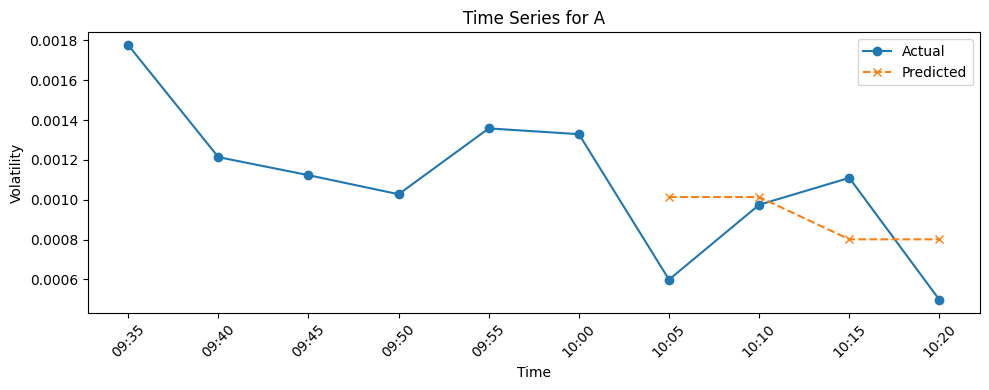

Overall missing predicted.volatility: 549234 out of 6101239 rows (9.00%)


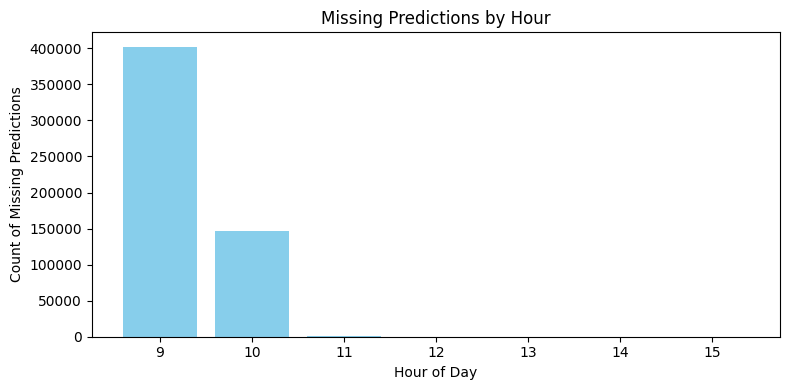


Top 10 symbols with missing predictions:
symbol
WWD     591
THC     586
SAIA    584
TEL     583
CASY    581
OLED    581
CYTK    579
UTHR    577
JBHT    576
ERIE    574
dtype: int64
Overall Metrics:
  rmse: 0.0008
  mae: 0.0002
  pearson_corr: 0.6575
  spearman_corr: 0.7940


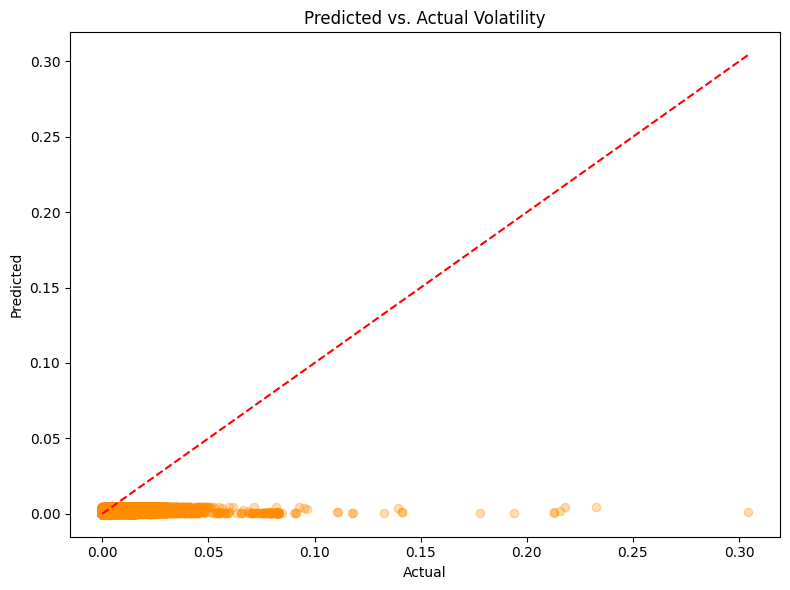

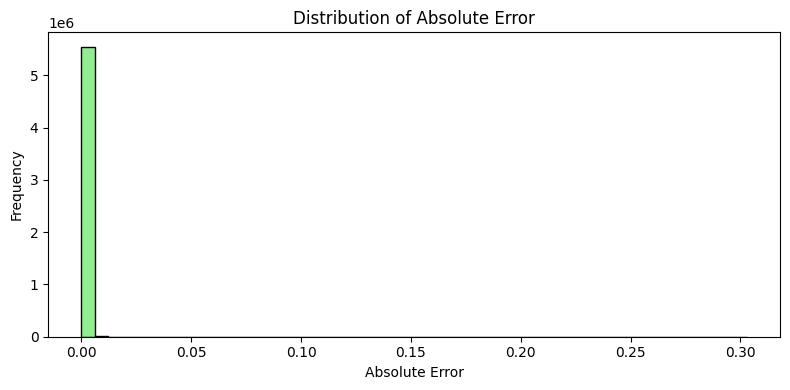

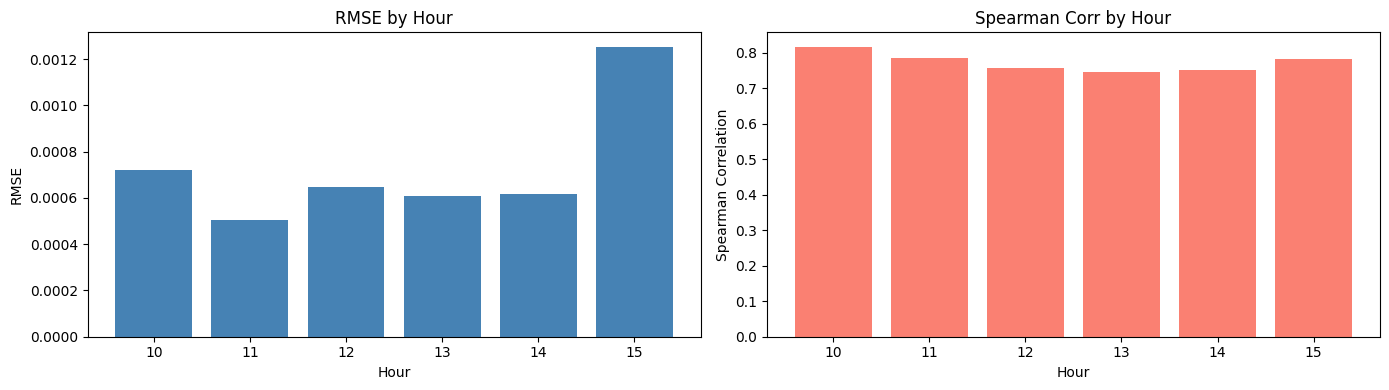

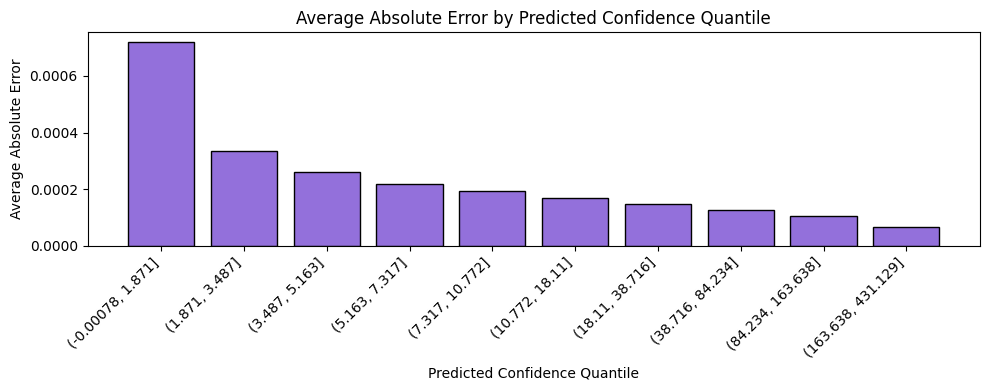


Regime Metrics:
                rmse  spearman_corr  avg_confidence      n_obs
vol_regime                                                    
Very Low    0.000207       0.363277      115.492351  1191554.0
Low         0.000158       0.219004       62.751982  1192395.0
Medium      0.000192       0.227844       29.849307  1158893.0
High        0.000286       0.305719       11.291538  1077052.0
Very High   0.001798       0.629276        3.440633   932111.0


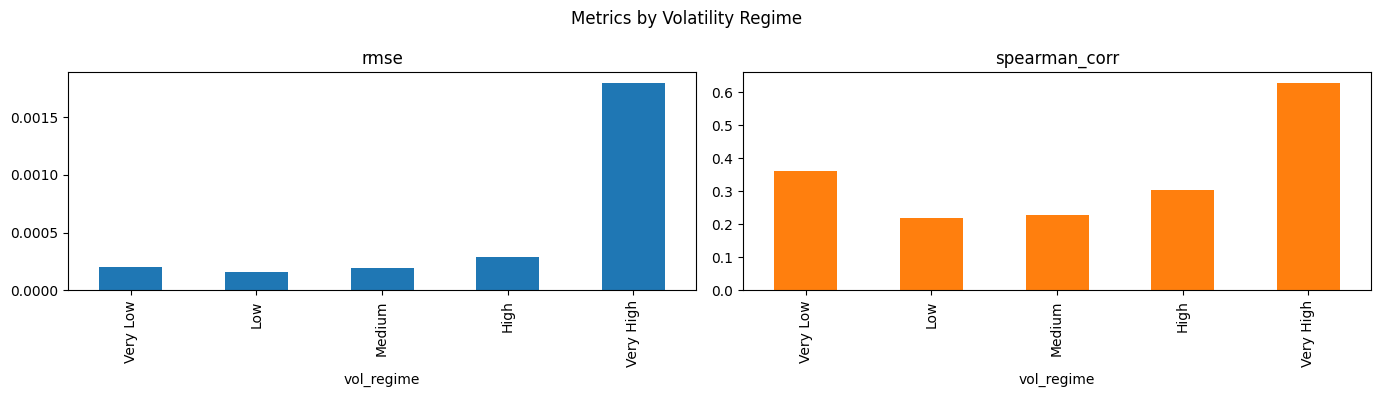

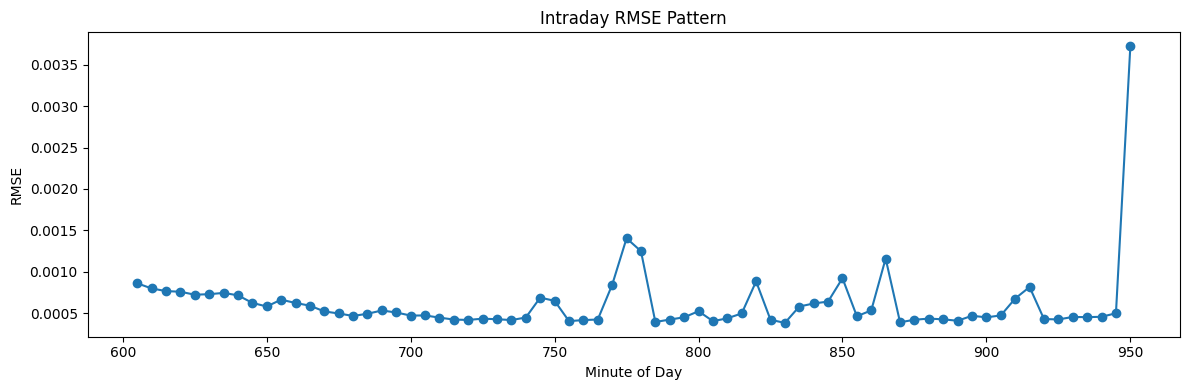


Overall Symbol-Level Performance Summary:
       rmse_original  rmse_scaled  spearman_corr  avg_confidence  \
count    1490.000000  1490.000000    1490.000000     1490.000000   
mean        0.000708     0.000707       0.546184       37.634878   
std         0.001046     0.001027       0.117508       57.459313   
min         0.000017     0.000018      -0.053673        0.001797   
25%         0.000287     0.000292       0.484652        3.554907   
50%         0.000437     0.000444       0.567575        9.641809   
75%         0.000723     0.000733       0.621146       48.209290   
max         0.018081     0.017974       0.803903      285.578856   

         avg_target  n_observations  n_unique_preds  
count  1.490000e+03     1490.000000     1490.000000  
mean   9.064077e-04     3726.177852      914.197315  
std    1.101643e-03     2284.997328      490.184512  
min    2.515614e-07       28.000000       15.000000  
25%    4.469522e-04     1255.750000      425.250000  
50%    5.873739e-04 

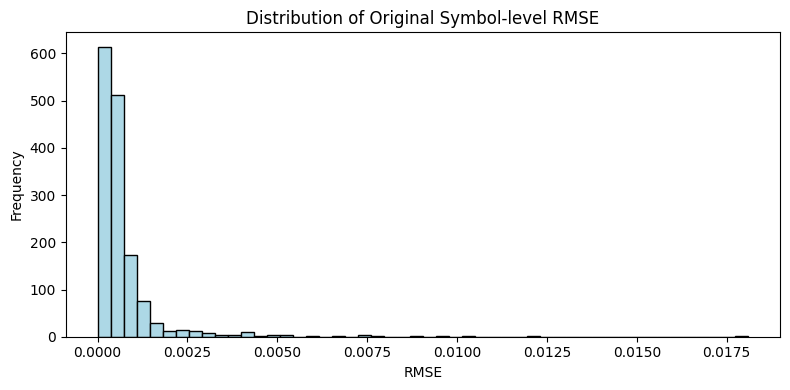


Top 10 symbols by Spearman correlation:
        spearman_corr  n_observations  n_unique_preds
symbol                                               
SMCI         0.803903          6333.0          1704.0
YINN         0.802741          3387.0          1225.0
SOUN         0.799820          4262.0          1256.0
JEPQ         0.790777          4882.0           955.0
ASHR         0.787708          3538.0          1044.0
PLTR         0.785743          6346.0          1735.0
KWEB         0.781355          5862.0          1476.0
MCHI         0.778985          5319.0          1212.0
TSLA         0.776633          6370.0          1706.0
NVD          0.774006            40.0            21.0

Overall Metrics:
{'rmse': 0.0007619855890247688, 'mae': 0.0002343410776119085, 'pearson_corr': 0.657545086764673, 'spearman_corr': 0.7940362789801769, 'time_of_day': {'hours': [10, 11, 12, 13, 14, 15], 'rmse': [0.000720585169704641, 0.000506492952172275, 0.0006453075531055664, 0.0006098695175615308, 0.0006152

In [9]:


# Perform basic data quality checks.
check_data_quality(df)

# Analyze missing predictions.
analyze_missing_predictions(df)

# Compute and display overall prediction metrics and generate plots.
overall_metrics = analyze_predictions(df)

# Analyze performance across volatility regimes.
regime_metrics = analyze_regimes(df)

# Analyze intraday error patterns.
intraday_metrics = analyze_intraday_pattern(df)

# Compute cross-sectional (symbol-level) metrics.
symbol_metrics = compute_symbol_metrics(df)

# Analyze symbol-level performance with scaling adjustment.
symbol_perf = analyze_symbol_performance(df)

# Optionally, save the summaries to CSV files.
symbol_metrics.to_csv("symbol_metrics_summary.csv", index=True)
symbol_perf.to_csv("symbol_performance.csv", index=True)

# Print final summaries.
print("\nOverall Metrics:")
print(overall_metrics)
print("\nRegime Metrics:")
print(regime_metrics)
print("\nIntraday Metrics (first 10 rows):")
print(intraday_metrics.head(10))
print("\nTop 10 Symbols by Spearman Correlation:")
print(symbol_perf.sort_values('spearman_corr', ascending=False).head(10)[['spearman_corr', 'n_observations', 'n_unique_preds']])



In [3]:
analyze_predictions_relative_error(df)

NameError: name 'df' is not defined

# Confidence Vol Relationship

In [10]:
def analyze_confidence_vol_relationship_fixed(df, conf_col='predicted.vol_confidence',
                                           vol_col='Y_log_vol_10min_lag_1m',
                                           pred_col='predicted.volatility'):
    """
    Analyze relationship between prediction confidence and realized volatility,
    using pre-computed quintile columns.
    """
    # Remove NaN values
    valid_data = df.dropna(subset=[conf_col, vol_col, pred_col]).copy()

    # Compute absolute error
    valid_data['abs_error'] = np.abs(valid_data[pred_col] - valid_data[vol_col])

    # Use existing quintile columns
    conf_quintile_column_name = f'{conf_col}_quintile'
    vol_quintile_column_name = f'{vol_col}_quintile'

    # Modified error metrics that don't require division by target
    quintile_stats = valid_data.groupby(conf_quintile_column_name).agg({
        vol_col: ['mean', 'std', 'count', lambda x: np.sum(x == 0)],
        'abs_error': ['mean', 'std', 'median'],
        pred_col: ['mean', 'std']
    }).round(6)

    # Rename the zero count column
    quintile_stats[vol_col] = quintile_stats[vol_col].rename(
        columns={'<lambda_0>': 'zero_vol_count'})

    print("\n1. Basic Statistics by Confidence Quintile:")
    print(quintile_stats)

    # Accuracy bands analysis
    def compute_accuracy_bands(group):
        total = len(group)
        bands = {
            'within_10pct': np.sum(group['abs_error'] <= 0.0001) / total,  # Within 0.01%
            'within_25pct': np.sum(group['abs_error'] <= 0.00025) / total, # Within 0.025%
            'within_50pct': np.sum(group['abs_error'] <= 0.0005) / total,  # Within 0.05%
            'above_100pct': np.sum(group['abs_error'] > 0.001) / total,    # Above 0.1%
            'count': total
        }
        return pd.Series(bands)

    accuracy_bands = valid_data.groupby(conf_quintile_column_name).apply(compute_accuracy_bands)

    print("\n2. Accuracy Bands by Confidence Level:")
    print(accuracy_bands.round(4))

    # Confidence vs Volatility Level analysis using existing quintiles
    conf_by_vol = valid_data.groupby(vol_quintile_column_name)[conf_col].agg(['mean', 'std', 'count']).round(4)

    print("\n3. Confidence by Volatility Level:")
    print(conf_by_vol)

    # Day pattern analysis
    valid_data['hour'] = pd.to_datetime(valid_data['minute'], format='%H:%M').dt.hour

    # Compute various metrics by hour
    hourly_metrics = valid_data.groupby('hour').agg({
        conf_col: ['mean', 'std'],
        'abs_error': ['mean', 'std'],
        vol_col: ['mean', 'std']
    }).round(6)

    print("\n4. Hourly Pattern Analysis:")
    print(hourly_metrics)

    # Plot key relationships
    plt.figure(figsize=(15, 5))

    # Plot 1: Error Distribution by Confidence
    plt.subplot(1, 3, 1)
    error_by_conf = valid_data.groupby(conf_quintile_column_name)['abs_error'].mean()
    plt.plot(range(5), error_by_conf.values, 'bo-')
    plt.title('Mean Error by Confidence')
    plt.xticks(range(5), error_by_conf.index, rotation=45)

    # Plot 2: Confidence vs Actual Volatility Level
    plt.subplot(1, 3, 2)
    conf_by_vol_mean = valid_data.groupby(vol_quintile_column_name)[conf_col].mean()
    plt.plot(range(5), conf_by_vol_mean.values, 'ro-')
    plt.title('Average Confidence by Vol Level')
    plt.xticks(range(5), conf_by_vol_mean.index, rotation=45)

    # Plot 3: Hour of Day Pattern
    plt.subplot(1, 3, 3)
    hourly_conf = valid_data.groupby('hour')[conf_col].mean()
    plt.plot(hourly_conf.index, hourly_conf.values, 'go-')
    plt.title('Confidence by Hour')

    plt.tight_layout()
    plt.show()

    return {
        'quintile_stats': quintile_stats,
        'accuracy_bands': accuracy_bands,
        'conf_by_vol': conf_by_vol,
        'hourly_metrics': hourly_metrics
    }


1. Basic Statistics by Confidence Quintile:
                                  Y_log_vol_10min_lag_1m                     \
                                                    mean       std    count   
predicted.vol_confidence_quintile                                             
VL                                              0.001580  0.001613  1111336   
L                                               0.000702  0.000748  1110515   
M                                               0.000546  0.000673  1110216   
H                                               0.000426  0.000489  1110670   
VH                                              0.000281  0.000374  1109268   

                                             abs_error                      \
                                  <lambda_0>      mean       std    median   
predicted.vol_confidence_quintile                                            
VL                                       NaN  0.000526  0.001137  0.000340   
L         

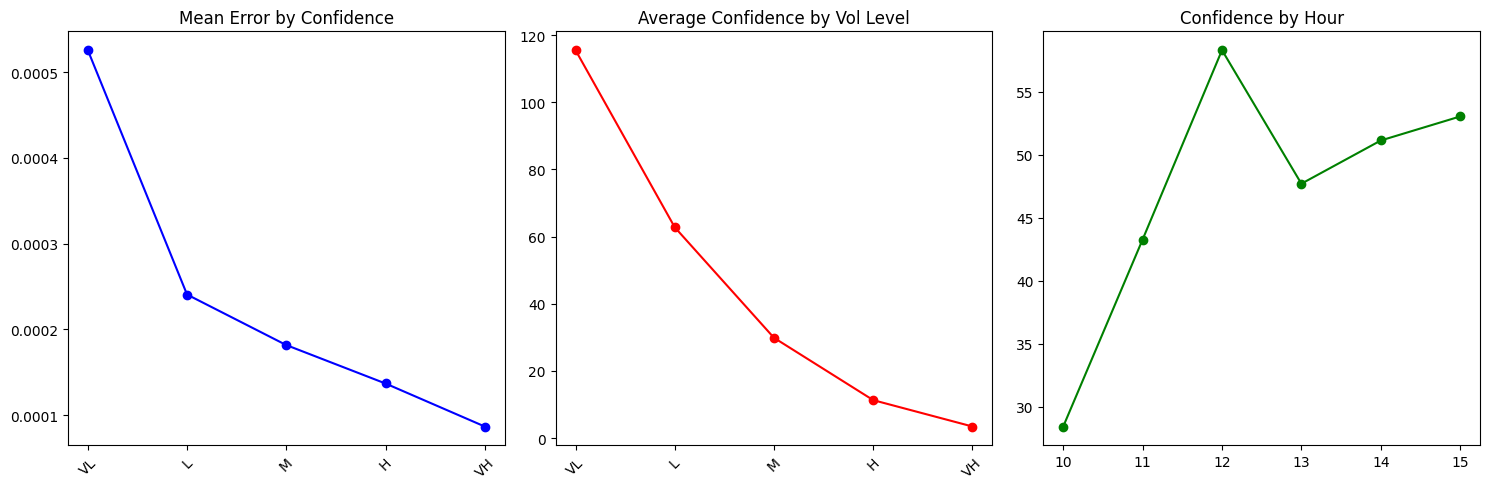

{'quintile_stats':                                   Y_log_vol_10min_lag_1m                     \
                                                     mean       std    count   
 predicted.vol_confidence_quintile                                             
 VL                                              0.001580  0.001613  1111336   
 L                                               0.000702  0.000748  1110515   
 M                                               0.000546  0.000673  1110216   
 H                                               0.000426  0.000489  1110670   
 VH                                              0.000281  0.000374  1109268   
 
                                              abs_error                      \
                                   <lambda_0>      mean       std    median   
 predicted.vol_confidence_quintile                                            
 VL                                       NaN  0.000526  0.001137  0.000340   
 L                      

In [11]:
def analyze_confidence_vol_relationship_fixed(df, conf_col='predicted.vol_confidence',
                                           vol_col='Y_log_vol_10min_lag_1m',
                                           pred_col='predicted.volatility'):
    """
    Analyze relationship between prediction confidence and realized volatility,
    using pre-computed quintile columns.
    """
    # Remove NaN values
    valid_data = df.dropna(subset=[conf_col, vol_col, pred_col]).copy()

    # Compute absolute error
    valid_data['abs_error'] = np.abs(valid_data[pred_col] - valid_data[vol_col])

    # Use existing quintile columns
    conf_quintile_column_name = f'{conf_col}_quintile'
    vol_quintile_column_name = f'{vol_col}_quintile'

    # Modified error metrics that don't require division by target
    quintile_stats = valid_data.groupby(conf_quintile_column_name).agg({
        vol_col: ['mean', 'std', 'count', lambda x: np.sum(x == 0)],
        'abs_error': ['mean', 'std', 'median'],
        pred_col: ['mean', 'std']
    }).round(6)

    # Rename the zero count column
    quintile_stats[vol_col] = quintile_stats[vol_col].rename(
        columns={'<lambda_0>': 'zero_vol_count'})

    print("\n1. Basic Statistics by Confidence Quintile:")
    print(quintile_stats)

    # Accuracy bands analysis
    def compute_accuracy_bands(group):
        total = len(group)
        bands = {
            'within_10pct': np.sum(group['abs_error'] <= 0.0001) / total,  # Within 0.01%
            'within_25pct': np.sum(group['abs_error'] <= 0.00025) / total, # Within 0.025%
            'within_50pct': np.sum(group['abs_error'] <= 0.0005) / total,  # Within 0.05%
            'above_100pct': np.sum(group['abs_error'] > 0.001) / total,    # Above 0.1%
            'count': total
        }
        return pd.Series(bands)

    accuracy_bands = valid_data.groupby(conf_quintile_column_name).apply(compute_accuracy_bands)

    print("\n2. Accuracy Bands by Confidence Level:")
    print(accuracy_bands.round(4))

    # Confidence vs Volatility Level analysis using existing quintiles
    conf_by_vol = valid_data.groupby(vol_quintile_column_name)[conf_col].agg(['mean', 'std', 'count']).round(4)

    print("\n3. Confidence by Volatility Level:")
    print(conf_by_vol)

    # Day pattern analysis
    valid_data['hour'] = pd.to_datetime(valid_data['minute'], format='%H:%M').dt.hour

    # Compute various metrics by hour
    hourly_metrics = valid_data.groupby('hour').agg({
        conf_col: ['mean', 'std'],
        'abs_error': ['mean', 'std'],
        vol_col: ['mean', 'std']
    }).round(6)

    print("\n4. Hourly Pattern Analysis:")
    print(hourly_metrics)

    # Plot key relationships
    plt.figure(figsize=(15, 5))

    # Plot 1: Error Distribution by Confidence
    plt.subplot(1, 3, 1)
    error_by_conf = valid_data.groupby(conf_quintile_column_name)['abs_error'].mean()
    plt.plot(range(5), error_by_conf.values, 'bo-')
    plt.title('Mean Error by Confidence')
    plt.xticks(range(5), error_by_conf.index, rotation=45)

    # Plot 2: Confidence vs Actual Volatility Level
    plt.subplot(1, 3, 2)
    conf_by_vol_mean = valid_data.groupby(vol_quintile_column_name)[conf_col].mean()
    plt.plot(range(5), conf_by_vol_mean.values, 'ro-')
    plt.title('Average Confidence by Vol Level')
    plt.xticks(range(5), conf_by_vol_mean.index, rotation=45)

    # Plot 3: Hour of Day Pattern
    plt.subplot(1, 3, 3)
    hourly_conf = valid_data.groupby('hour')[conf_col].mean()
    plt.plot(hourly_conf.index, hourly_conf.values, 'go-')
    plt.title('Confidence by Hour')

    plt.tight_layout()
    plt.show()

    return {
        'quintile_stats': quintile_stats,
        'accuracy_bands': accuracy_bands,
        'conf_by_vol': conf_by_vol,
        'hourly_metrics': hourly_metrics
    }




# Analysis of Predictions

In [12]:
def analyze_prediction_signs(df, conf_col='predicted.vol_confidence',
                           vol_col='Y_log_vol_10min_lag_1m',
                           pred_col='predicted.volatility'):
    """
    Analyze the sign flip phenomenon in predictions across confidence levels.
    """
    print("\nAnalyzing Sign Patterns in Predictions")
    print("=" * 50)

    # Clean data
    valid_data = df.dropna(subset=[conf_col, vol_col, pred_col]).copy()

    # Create confidence deciles for finer granularity
    valid_data['conf_decile'] = pd.qcut(valid_data[conf_col], 10,
                                      labels=[f'D{i+1}' for i in range(10)])

    # Add useful derived columns
    valid_data['pred_sign'] = np.sign(valid_data[pred_col])
    valid_data['pred_magnitude'] = np.abs(valid_data[pred_col])
    valid_data['error'] = valid_data[pred_col] - valid_data[vol_col]
    valid_data['rel_error'] = valid_data['error'] / valid_data[vol_col].clip(lower=1e-10)
    valid_data['hour'] = pd.to_datetime(valid_data['minute'], format='%H:%M').dt.hour

    # 1. Basic sign statistics by confidence decile
    sign_stats = valid_data.groupby('conf_decile').agg({
        'pred_sign': ['mean', 'std', 'size'],  # size gives us count
        'pred_magnitude': ['mean', 'std'],
        pred_col: ['mean', 'std'],
        vol_col: ['mean', 'std'],
        'error': ['mean', 'std']
    }).round(6)

    print("\n1. Sign Statistics by Confidence Decile:")
    print(sign_stats)

    # 2. Transition analysis
    valid_data = valid_data.sort_values(['symbol', 'date', 'minute'])
    valid_data['sign_change'] = (valid_data.groupby('symbol')['pred_sign']
                                .transform(lambda x: (x != x.shift()).astype(float)))

    # Analyze sign changes by confidence
    sign_changes = valid_data.groupby('conf_decile').agg({
        'sign_change': ['mean', 'sum', 'size']
    }).round(4)

    print("\n2. Sign Changes by Confidence Decile:")
    print(sign_changes)

    # 3. Time of day analysis
    time_pattern = valid_data.groupby(['hour', 'conf_decile']).agg({
        'pred_sign': ['mean', 'std'],
        'pred_magnitude': 'mean',
        'error': 'mean',
        pred_col: 'size'  # Count of predictions
    }).round(6)

    print("\n3. Time of Day Patterns:")
    print(time_pattern)

    # 4. Visualization
    plt.figure(figsize=(15, 5))

    # Plot 1: Average prediction by confidence decile
    plt.subplot(1, 3, 1)
    decile_means = valid_data.groupby('conf_decile')[pred_col].mean()
    plt.plot(range(10), decile_means.values, 'bo-')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.title('Mean Prediction by Confidence Decile')
    plt.xticks(range(10), decile_means.index, rotation=45)
    plt.ylabel('Mean Prediction')

    # Plot 2: Sign changes by confidence
    plt.subplot(1, 3, 2)
    sign_flip_rate = sign_changes['sign_change']['mean']
    plt.plot(range(10), sign_flip_rate.values, 'ro-')
    plt.title('Sign Change Rate by Confidence')
    plt.xticks(range(10), sign_flip_rate.index, rotation=45)
    plt.ylabel('Sign Change Rate')

    # Plot 3: Error magnitude vs confidence
    plt.subplot(1, 3, 3)
    error_magnitude = valid_data.groupby('conf_decile')['error'].apply(lambda x: np.abs(x).mean())
    plt.plot(range(10), error_magnitude.values, 'go-')
    plt.title('Mean Absolute Error by Confidence')
    plt.xticks(range(10), error_magnitude.index, rotation=45)
    plt.ylabel('Mean Absolute Error')

    plt.tight_layout()
    plt.show()

    # 5. Volatility level analysis
    vol_quintiles = pd.qcut(valid_data[vol_col], 5, labels=['VL', 'L', 'M', 'H', 'VH'])
    valid_data['vol_quintile'] = vol_quintiles

    controlled_analysis = valid_data.groupby(['vol_quintile', 'conf_decile']).agg({
        pred_col: ['mean', 'std'],
        'pred_sign': 'mean',
        'error': ['mean', 'std'],
        pred_col: 'size'  # Using pred_col for count since we know it exists
    }).round(6)

    print("\n4. Analysis by Volatility Level and Confidence:")
    print(controlled_analysis)

    # 6. Analyze sequential behavior
    sequence_analysis = valid_data.groupby('symbol').agg({
        'sign_change': ['mean', 'sum'],
        conf_col: ['mean', 'std'],
        pred_col: ['mean', 'std'],
        'error': ['mean', 'std']
    }).round(6)

    print("\n5. Sequential Behavior by Symbol:")
    print(sequence_analysis.describe())

    return {
        'sign_stats': sign_stats,
        'sign_changes': sign_changes,
        'time_pattern': time_pattern,
        'vol_confidence_analysis': controlled_analysis,
        'sequence_analysis': sequence_analysis
    }


Analyzing Sign Patterns in Predictions

1. Sign Statistics by Confidence Decile:
            pred_sign                   pred_magnitude            \
                 mean       std    size           mean       std   
conf_decile                                                        
D1           1.000000  0.000000  555378       0.002026  0.000834   
D2           1.000000  0.000000  555958       0.001000  0.000244   
D3           1.000000  0.000000  554823       0.000732  0.000180   
D4           1.000000  0.000000  555692       0.000606  0.000148   
D5           1.000000  0.000000  556471       0.000535  0.000118   
D6           1.000000  0.000000  553745       0.000476  0.000092   
D7           0.999950  0.010041  555447       0.000420  0.000076   
D8           0.999319  0.036894  555223       0.000364  0.000066   
D9           0.996071  0.088562  555307       0.000301  0.000071   
D10          0.994711  0.102715  553961       0.000216  0.000080   

            predicted.volatility 

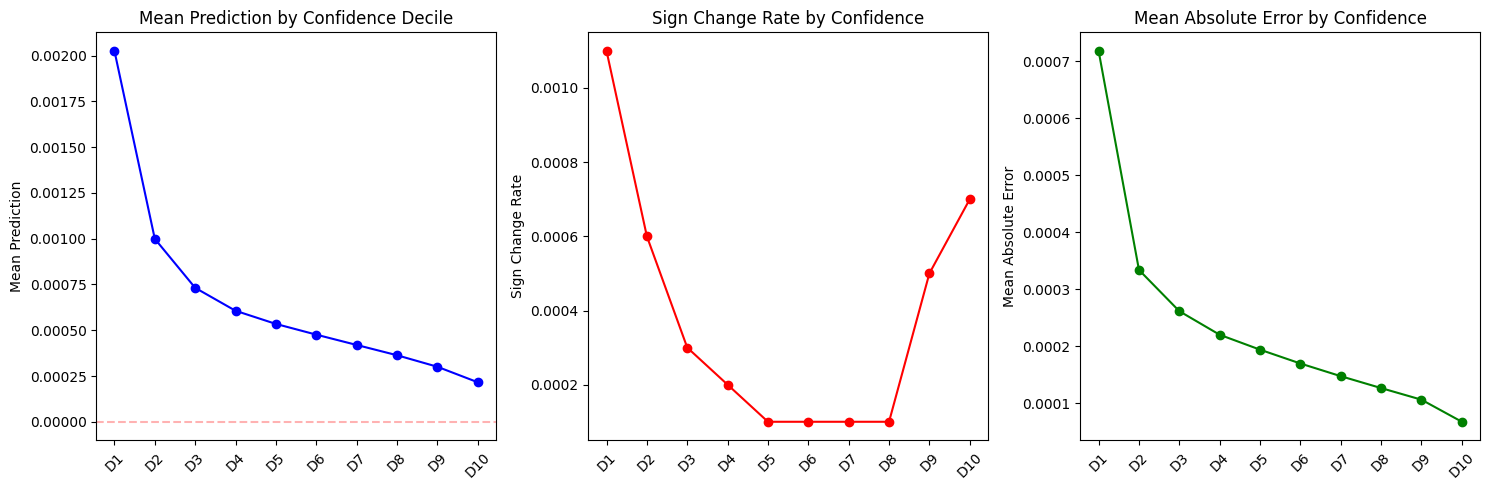


4. Analysis by Volatility Level and Confidence:
                         predicted.volatility pred_sign     error          
                                         size      mean      mean       std
vol_quintile conf_decile                                                   
VL           D1                          9671  1.000000  0.001090  0.000586
             D2                         20727  1.000000  0.000523  0.000180
             D3                         39726  1.000000  0.000361  0.000127
             D4                         56181  1.000000  0.000278  0.000106
             D5                         64738  1.000000  0.000234  0.000094
             D6                         75831  1.000000  0.000200  0.000083
             D7                        100256  0.999721  0.000161  0.000074
             D8                        142926  0.997411  0.000121  0.000068
             D9                        223339  0.990230  0.000076  0.000064
             D10                       

{'sign_stats':             pred_sign                   pred_magnitude            \
                  mean       std    size           mean       std   
 conf_decile                                                        
 D1           1.000000  0.000000  555378       0.002026  0.000834   
 D2           1.000000  0.000000  555958       0.001000  0.000244   
 D3           1.000000  0.000000  554823       0.000732  0.000180   
 D4           1.000000  0.000000  555692       0.000606  0.000148   
 D5           1.000000  0.000000  556471       0.000535  0.000118   
 D6           1.000000  0.000000  553745       0.000476  0.000092   
 D7           0.999950  0.010041  555447       0.000420  0.000076   
 D8           0.999319  0.036894  555223       0.000364  0.000066   
 D9           0.996071  0.088562  555307       0.000301  0.000071   
 D10          0.994711  0.102715  553961       0.000216  0.000080   
 
             predicted.volatility           Y_log_vol_10min_lag_1m            \
       

In [13]:
analyze_prediction_signs(df)

In [14]:
def analyze_joint_predictions(df,
                              vol_pred='predicted.volatility',
                              ret_pred='predicted.returns',
                              vol_conf='predicted.vol_confidence',
                              ret_conf='predicted.ret_confidence',
                              vol_target='Y_log_vol_10min_lag_1m',
                              ret_target='Y_log_ret_60min_lag_1m'):
    """
    Analyze joint predictions with focus on capital allocation implications.
    """
    print("\nAnalyzing Joint Prediction Patterns")
    print("=" * 50)

    # Clean data
    valid_data = df.dropna(subset=[vol_pred, ret_pred, vol_conf, ret_conf,
                                   vol_target, ret_target]).copy()

    # Add derived columns
    valid_data['vol_error'] = valid_data[vol_pred] - valid_data[vol_target]
    valid_data['ret_error'] = valid_data[ret_pred] - valid_data[ret_target]
    valid_data['vol_error_magnitude'] = np.abs(valid_data['vol_error'])
    valid_data['ret_error_magnitude'] = np.abs(valid_data['ret_error'])


    # 1. Joint Confidence Analysis
    joint_conf = valid_data.groupby([f'{ret_conf}_quintile',
                                     f'{vol_conf}_quintile']).agg({
        'ret_error_magnitude': ['mean', 'std', 'count'],
        'vol_error_magnitude': ['mean', 'std'],
        ret_target: ['mean', 'std'],
        vol_target: ['mean', 'std']
    }).round(6)

    print("\n1. Joint Confidence Analysis:")
    print(joint_conf)

    # 2. High Confidence Analysis
    high_conf = valid_data[
        (valid_data[f'{ret_conf}_quintile'] == 'VH') &
        (valid_data[f'{vol_conf}_quintile'] == 'VH')
    ]

    print("\n2. High Joint Confidence Statistics:")
    print(high_conf[[ret_pred, vol_pred, ret_target, vol_target]].describe())

    # 3. Asymmetric Cost Analysis
    def compute_asymmetric_cost(group, ret_weight=2.0):
        """
        Compute asymmetric cost metric:
        - Over-prediction of returns weighted more heavily (actual capital loss)
        - Under-prediction of volatility weighted more heavily (missing opportunity)
        """
        ret_over = (group['ret_error'] > 0).mean()
        vol_under = (group['vol_error'] < 0).mean()
        ret_cost = ret_over * ret_weight
        vol_cost = vol_under
        return pd.Series({
            'ret_over_rate': ret_over,
            'vol_under_rate': vol_under,
            'combined_cost': ret_cost + vol_cost,
            'count': len(group)
        })

    def add_percentage_annotations(plt, data_matrix, percentage_matrix, conf_levels, threshold=None):
        """
        Add percentage annotations to a heatmap plot.
        """
        if threshold is None:
            threshold = np.mean(data_matrix)
        for i in range(len(conf_levels)):
            for j in range(len(conf_levels)):
                plt.text(j, i, f'{percentage_matrix[i][j]:.1f}%',
                         ha='center', va='center',
                         color='black' if data_matrix[i][j] < threshold else 'white')
        plt.xticks(range(len(conf_levels)), conf_levels)
        plt.yticks(range(len(conf_levels)), conf_levels)

    cost_analysis = valid_data.groupby([f'{ret_conf}_quintile',
                                        f'{vol_conf}_quintile']).apply(compute_asymmetric_cost)

    print("\n3. Asymmetric Cost Analysis:")
    print(cost_analysis)

    # 4. Visualization
    plt.figure(figsize=(15, 5))

    # Plot 1: Return Prediction Error vs Joint Confidence
    plt.subplot(1, 3, 1)
    conf_levels = ['VL', 'L', 'M', 'H', 'VH']

    errors = np.array([[valid_data[
        (valid_data[f'{ret_conf}_quintile'] == ret_level) &
        (valid_data[f'{vol_conf}_quintile'] == vol_level)
    ]['ret_error_magnitude'].mean() for ret_level in conf_levels]
        for vol_level in conf_levels])

    counts = np.array([[len(valid_data[
        (valid_data[f'{ret_conf}_quintile'] == ret_level) &
        (valid_data[f'{vol_conf}_quintile'] == vol_level)
    ]) for ret_level in conf_levels]
        for vol_level in conf_levels])

    total_samples = counts.sum()
    percentages = counts / total_samples * 100

    im = plt.imshow(errors, cmap='YlOrRd')
    plt.colorbar(label='Mean Return Error')
    add_percentage_annotations(plt, errors, percentages, conf_levels)
    plt.title('Joint Confidence vs Return Error')
    plt.xlabel('Return Confidence')
    plt.ylabel('Vol Confidence')

    # Plot 2: Success Rate
    plt.subplot(1, 3, 2)
    def compute_pnl_ratio(group):
        """Ratio of successful to unsuccessful scaled trades"""
        correct_dir = np.sign(group[ret_pred]) == np.sign(group[ret_target])
        good_scale = np.sign(group[vol_pred]) == np.sign(group[vol_target])
        return (correct_dir & good_scale).sum() / len(group)

    pnl_ratios = np.array([[valid_data[
        (valid_data[f'{ret_conf}_quintile'] == ret_level) &
        (valid_data[f'{vol_conf}_quintile'] == vol_level)
    ].pipe(compute_pnl_ratio) for ret_level in conf_levels]
        for vol_level in conf_levels])

    plt.imshow(pnl_ratios, cmap='RdYlGn')
    plt.colorbar(label='Success Ratio')
    add_percentage_annotations(plt, pnl_ratios, percentages, conf_levels, threshold=0.5)
    plt.title('Joint Prediction Success Rate')
    plt.xlabel('Return Confidence')
    plt.ylabel('Vol Confidence')

    # Plot 3: Asymmetric Cost
    plt.subplot(1, 3, 3)
    costs = np.array([[valid_data[
        (valid_data[f'{ret_conf}_quintile'] == ret_level) &
        (valid_data[f'{vol_conf}_quintile'] == vol_level)
    ].pipe(lambda x: compute_asymmetric_cost(x)['combined_cost']) for ret_level in conf_levels]
        for vol_level in conf_levels])

    plt.imshow(costs, cmap='YlOrRd')
    plt.colorbar(label='Combined Cost')
    add_percentage_annotations(plt, costs, percentages, conf_levels, threshold=0.5)
    plt.title('Asymmetric Cost by Confidence')
    plt.xlabel('Return Confidence')
    plt.ylabel('Vol Confidence')

    plt.tight_layout()
    plt.show()

    # 5. Time of Day Pattern
    valid_data['hour'] = pd.to_datetime(valid_data['minute'], format='%H:%M').dt.hour
    time_pattern = valid_data.groupby('hour').agg({
        'ret_error_magnitude': ['mean', 'std'],
        'vol_error_magnitude': ['mean', 'std'],
        ret_conf: 'mean',
        vol_conf: 'mean'
    }).round(6)

    print("\n4. Time of Day Pattern:")
    print(time_pattern)

    return {
        'joint_conf': joint_conf,
        'high_conf': high_conf.describe(),
        'cost_analysis': cost_analysis,
        'time_pattern': time_pattern
    }


Analyzing Joint Prediction Patterns

1. Joint Confidence Analysis:
                                                                    ret_error_magnitude  \
                                                                                   mean   
predicted.ret_confidence_quintile predicted.vol_confidence_quintile                       
VL                                VL                                           0.011594   
                                  L                                            0.006550   
                                  M                                            0.006544   
                                  H                                            0.005977   
                                  VH                                           0.005656   
L                                 VL                                           0.005880   
                                  L                                            0.005010   
                      

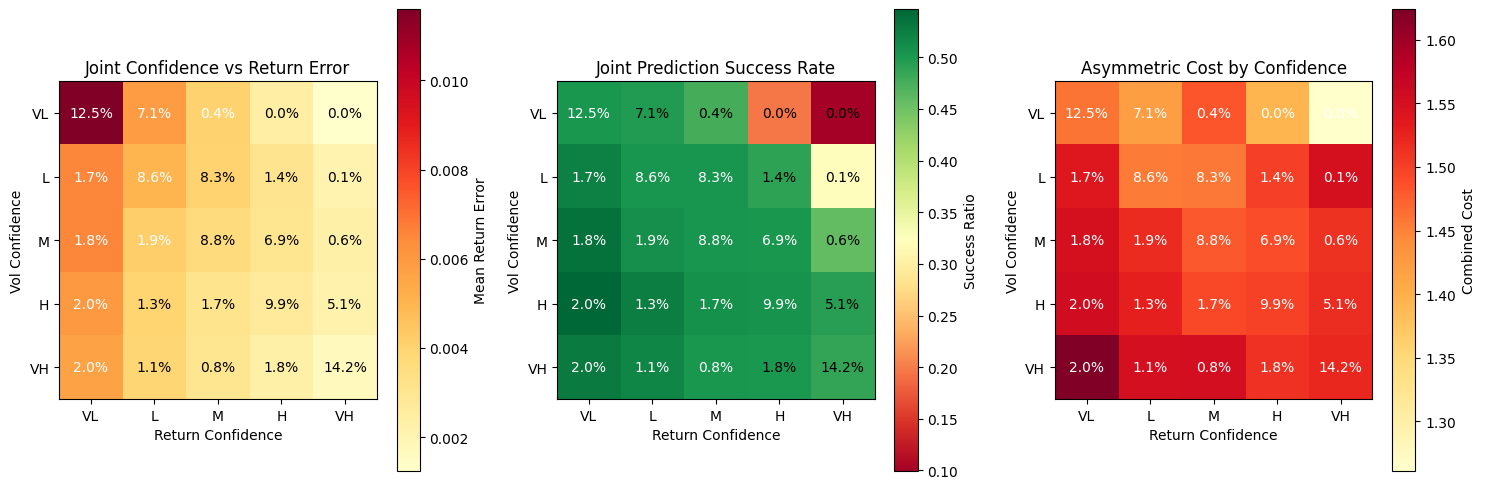


4. Time of Day Pattern:
     ret_error_magnitude           vol_error_magnitude            \
                    mean       std                mean       std   
hour                                                               
10              0.005860  0.008551            0.000304  0.000653   
11              0.004475  0.006428            0.000229  0.000452   
12              0.004091  0.007036            0.000208  0.000611   
13              0.003840  0.006082            0.000198  0.000577   
14              0.003829  0.006320            0.000196  0.000583   
15              0.005679  0.011882            0.000280  0.001221   

     predicted.ret_confidence predicted.vol_confidence  
                         mean                     mean  
hour                                                    
10                   0.108755                28.427607  
11                   0.153520                43.277001  
12                   0.175595                58.313182  
13                  

{'joint_conf':                                                                     ret_error_magnitude  \
                                                                                    mean   
 predicted.ret_confidence_quintile predicted.vol_confidence_quintile                       
 VL                                VL                                           0.011594   
                                   L                                            0.006550   
                                   M                                            0.006544   
                                   H                                            0.005977   
                                   VH                                           0.005656   
 L                                 VL                                           0.005880   
                                   L                                            0.005010   
                                   M                              

In [15]:
analyze_joint_predictions(df)

In [16]:
# Get correlations between return confidence, volatility confidence and actual returns
confidence_matrix = np.array([
    df['predicted.ret_confidence'].values,
    df['predicted.vol_confidence'].values,
    df['Y_log_ret_60min_lag_1m'].values
]).T

# Drop any rows with NaN values
confidence_matrix = confidence_matrix[~np.isnan(confidence_matrix).any(axis=1)]

# Calculate correlation matrix using numpy
corr_matrix = np.corrcoef(confidence_matrix.T)

print("\nCorrelation Matrix:")
print("Row/Col Order: Return Confidence, Vol Confidence, Actual Returns")
print(corr_matrix)

# For predicted values themselves (not confidences)
pred_matrix = np.array([
    df['predicted.returns'].values,
    df['predicted.volatility'].values,
    df['Y_log_ret_60min_lag_1m'].values,
    df['Y_log_vol_10min_lag_1m'].values
]).T

# Drop any rows with NaN values
pred_matrix = pred_matrix[~np.isnan(pred_matrix).any(axis=1)]

print("\nPrediction Matrix:")
print("Row/Col Order: Predicted Returns, Predicted Vol, Actual Returns, Actual Vol")
print(np.corrcoef(pred_matrix.T))


Correlation Matrix:
Row/Col Order: Return Confidence, Vol Confidence, Actual Returns
[[ 1.          0.72465177 -0.00510506]
 [ 0.72465177  1.          0.00498028]
 [-0.00510506  0.00498028  1.        ]]

Prediction Matrix:
Row/Col Order: Predicted Returns, Predicted Vol, Actual Returns, Actual Vol
[[ 1.         -0.56601726  0.03604525 -0.32850652]
 [-0.56601726  1.         -0.01852232  0.65754509]
 [ 0.03604525 -0.01852232  1.         -0.00501858]
 [-0.32850652  0.65754509 -0.00501858  1.        ]]


In [17]:
df.shape

(6101239, 35)

In [19]:
df.columns

Index(['minute', 'symbol', 'ts_event', 'mid', 'spread', 'imbalance',
       'Y_log_ret_10min', 'Y_log_ret_30min', 'Y_log_ret_60min',
       'Y_log_ret_10min_lag_1m', 'Y_log_ret_30min_lag_1m',
       'Y_log_ret_60min_lag_1m', 'roll_vol_10m', 'Y_log_vol_10min',
       'Y_log_vol_10min_lag_1m', 'valid_target_10m', 'valid_target_30m',
       'valid_target_60m', 'Y_log_ret_10min_partial',
       'Y_log_ret_30min_partial', 'Y_log_ret_60min_partial',
       'predicted.volatility', 'predicted.returns', 'predicted.vol_confidence',
       'predicted.ret_confidence', 'date', 'hour', 'minute_in_hour',
       'minutes_from_open', 'predicted.vol_confidence_quintile',
       'predicted.ret_confidence_quintile', 'predicted.returns_quintile',
       'predicted.volatility_quintile', 'Y_log_vol_10min_lag_1m_quintile',
       'Y_log_ret_60min_lag_1m_quintile'],
      dtype='object')

In [20]:
# Compute correlations by volatility confidence quintile
correlations = []
for quintile in ['VL', 'L', 'M', 'H', 'VH']:
    mask = (df['predicted.vol_confidence_quintile'] == quintile) & \
           ~np.isnan(df['predicted.volatility']) & \
           ~np.isnan(df['Y_log_vol_10min_lag_1m'])
    
    pred_vol = df.loc[mask, 'predicted.volatility'].values
    actual_vol = df.loc[mask, 'Y_log_vol_10min_lag_1m'].values
    
    if len(pred_vol) > 0:
        corr = np.corrcoef(pred_vol, actual_vol)[0,1]
        n_samples = len(pred_vol)
        rmse = np.sqrt(np.mean((pred_vol - actual_vol)**2))
        correlations.append({
            'quintile': quintile,
            'correlation': corr,
            'n_samples': n_samples,
            'rmse': rmse
        })

# Convert to DataFrame and display results
results = pd.DataFrame(correlations)
print("\nCorrelation Analysis by Volatility Confidence Quintile:")
print(results.round(4))


Correlation Analysis by Volatility Confidence Quintile:
  quintile  correlation  n_samples    rmse
0       VL       0.6490    1111336  0.0013
1        L       0.2421    1110515  0.0007
2        M       0.1892    1110216  0.0007
3        H       0.1821    1110670  0.0005
4       VH       0.2326    1109268  0.0004


Raw Predictive Power:
  Regression coefficient (alpha): 1.0933
  Pearson correlation: 0.6575
  R-squared: 0.4324


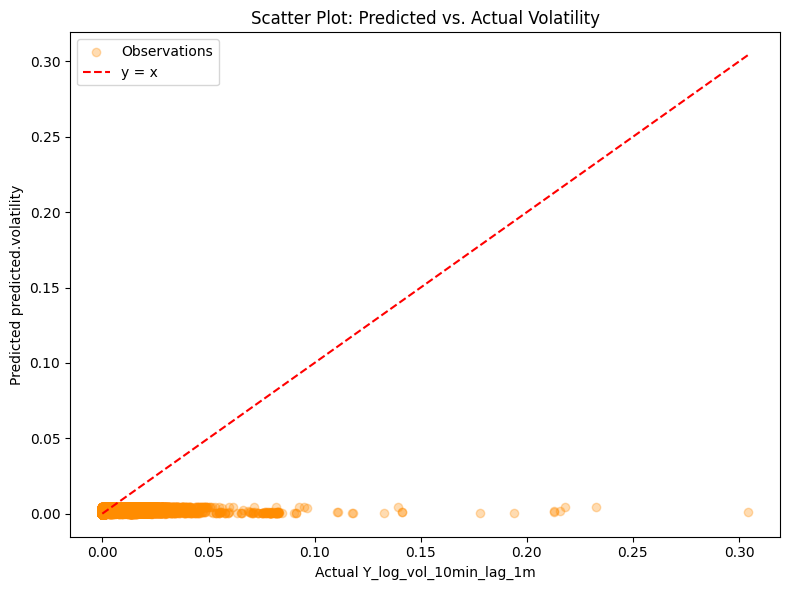


Spearman Correlation (per date & minute):
count    6370.000000
mean        0.761450
std         0.072271
min        -0.367269
25%         0.742906
50%         0.768840
75%         0.794312
max         0.927408
Name: spearman_corr, dtype: float64


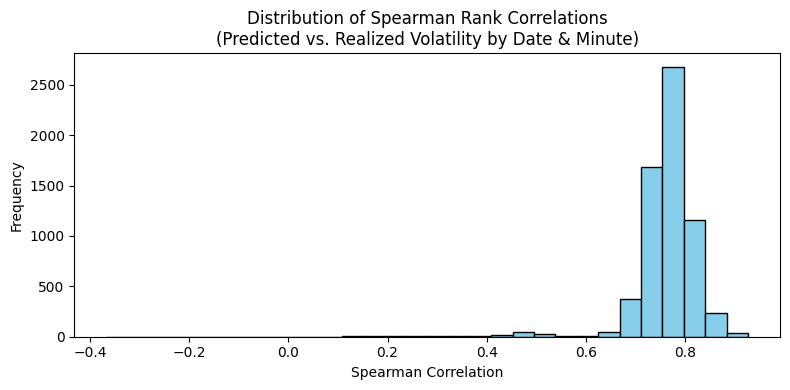


Volatility Confidence Score Statistics:
  Mean: 47.2624
  Median: 10.7720
  Standard Deviation: 72.2923


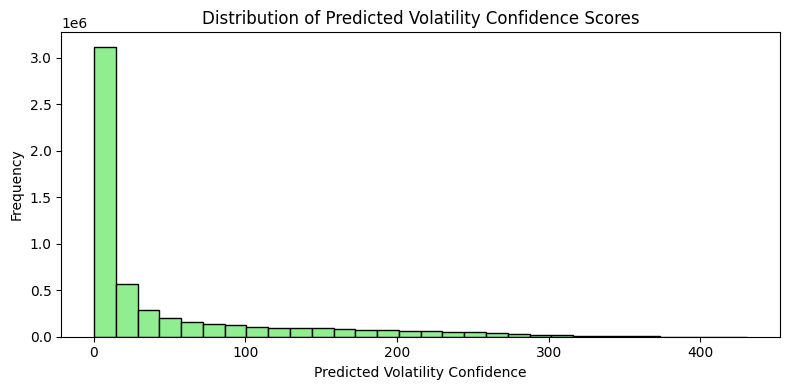

In [22]:

#############################################
# 1. Raw Predictive Power: Regression & Correlation
#############################################

# Define the target and prediction columns.
target_col = 'Y_log_vol_10min_lag_1m'
pred_col = 'predicted.volatility'

# Remove rows where either target or prediction is NaN.
valid_mask = ~df[target_col].isna() & ~df[pred_col].isna()
y = df.loc[valid_mask, target_col].values
y_hat = df.loc[valid_mask, pred_col].values

# --- Compute the regression coefficient (alpha) ---
# alpha = (sum(pred * target)) / (sum(pred^2))
alpha = np.sum(y_hat * y) / np.sum(y_hat * y_hat)
print("Raw Predictive Power:")
print(f"  Regression coefficient (alpha): {alpha:.4f}")

# --- Compute Pearson correlation (without scipy) ---
mean_yhat = np.mean(y_hat)
mean_y = np.mean(y)
numerator = np.sum((y_hat - mean_yhat) * (y - mean_y))
denom = np.sqrt(np.sum((y_hat - mean_yhat)**2) * np.sum((y - mean_y)**2))
pearson_corr = numerator / denom if denom != 0 else np.nan
print(f"  Pearson correlation: {pearson_corr:.4f}")

# --- Compute R-squared ---
r_squared = pearson_corr**2
print(f"  R-squared: {r_squared:.4f}")

# --- Visualization: Scatter plot of predicted vs. actual ---
plt.figure(figsize=(8, 6))
plt.scatter(y, y_hat, alpha=0.3, color='darkorange', label="Observations")
# Plot the y=x line for reference.
min_val = min(np.min(y), np.min(y_hat))
max_val = max(np.max(y), np.max(y_hat))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
plt.xlabel("Actual " + target_col)
plt.ylabel("Predicted " + pred_col)
plt.title("Scatter Plot: Predicted vs. Actual Volatility")
plt.legend()
plt.tight_layout()
plt.show()


#############################################
# 2. Distribution of Rank Correlations (Spearman) by Date & Minute
#############################################

# Define a helper function to compute Spearman correlation using ranks.
def compute_spearman(group):
    # Extract predicted and target values from the group.
    pred_vals = group[pred_col].values
    target_vals = group[target_col].values

    # Only compute if at least 2 observations exist.
    if len(pred_vals) < 2:
        return np.nan

    # Compute ranks by using argsort twice.
    pred_ranks = pred_vals.argsort().argsort().astype(float)
    target_ranks = target_vals.argsort().argsort().astype(float)

    mean_pred_ranks = np.mean(pred_ranks)
    mean_target_ranks = np.mean(target_ranks)
    numerator = np.sum((pred_ranks - mean_pred_ranks) * (target_ranks - mean_target_ranks))
    denominator = np.sqrt(np.sum((pred_ranks - mean_pred_ranks)**2) * np.sum((target_ranks - mean_target_ranks)**2))
    return numerator / denominator if denominator != 0 else np.nan

# Group the data by date and minute.
grouped = df.dropna(subset=[pred_col, target_col]).groupby(['date', 'minute'])
# Apply the Spearman function to each group.
spearman_corr_series = grouped.apply(compute_spearman)
# Convert to DataFrame for convenience.
spearman_corr_df = spearman_corr_series.reset_index(name='spearman_corr')

# Show summary statistics.
print("\nSpearman Correlation (per date & minute):")
print(spearman_corr_df['spearman_corr'].describe())

# Plot the distribution (histogram) of the rank correlations.
plt.figure(figsize=(8, 4))
plt.hist(spearman_corr_df['spearman_corr'].dropna(), bins=30, edgecolor='black', color='skyblue')
plt.title("Distribution of Spearman Rank Correlations\n(Predicted vs. Realized Volatility by Date & Minute)")
plt.xlabel("Spearman Correlation")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


#############################################
# 3. Distribution of the Volatility Confidence Score
#############################################

# Extract the volatility confidence scores.
vol_conf = df['predicted.vol_confidence'].dropna().values

# Print basic statistics.
print("\nVolatility Confidence Score Statistics:")
print(f"  Mean: {np.mean(vol_conf):.4f}")
print(f"  Median: {np.median(vol_conf):.4f}")
print(f"  Standard Deviation: {np.std(vol_conf):.4f}")

# Plot the histogram of volatility confidence scores.
plt.figure(figsize=(8, 4))
plt.hist(vol_conf, bins=30, edgecolor='black', color='lightgreen')
plt.title("Distribution of Predicted Volatility Confidence Scores")
plt.xlabel("Predicted Volatility Confidence")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
# Group by symbol to analyze cross-sectional prediction power
def analyze_vol_predictions(df):
    results = []
    
    for symbol in df['symbol'].unique():
        symbol_data = df[df['symbol'] == symbol].copy()
        
        # Skip if not enough data
        if len(symbol_data) < 10:
            continue
            
        # Get raw predictions and actual values
        pred_vol = symbol_data['predicted.volatility']
        actual_vol = symbol_data['Y_log_vol_10min_lag_1m']
        confidence = symbol_data['predicted.vol_confidence']
        
        # Remove any NaN values
        mask = ~np.isnan(pred_vol) & ~np.isnan(actual_vol) & ~np.isnan(confidence)
        pred_vol = pred_vol[mask]
        actual_vol = actual_vol[mask]
        confidence = confidence[mask]
        
        if len(pred_vol) < 10:  # Skip if too few valid observations
            continue
            
        # Calculate metrics for raw predictions
        raw_spearman = stats.spearmanr(pred_vol, actual_vol)[0]
        raw_rmse = np.sqrt(np.mean((pred_vol - actual_vol)**2))
        
        # Calculate confidence-weighted predictions
        # Normalize confidence to sum to 1 within each symbol
        norm_confidence = confidence / confidence.sum()
        weighted_pred = pred_vol * norm_confidence
        
        # Calculate metrics for weighted predictions
        weighted_spearman = stats.spearmanr(weighted_pred, actual_vol)[0]
        weighted_rmse = np.sqrt(np.mean((weighted_pred - actual_vol)**2))
        
        results.append({
            'symbol': symbol,
            'n_obs': len(pred_vol),
            'raw_spearman': raw_spearman,
            'weighted_spearman': weighted_spearman,
            'raw_rmse': raw_rmse,
            'weighted_rmse': weighted_rmse,
            'avg_confidence': confidence.mean(),
            'std_confidence': confidence.std()
        })
    
    return pd.DataFrame(results)

# Run the analysis
results = analyze_vol_predictions(df)

# Print summary statistics
print("\nSummary Statistics Across Stocks:")
print(results[['raw_spearman', 'weighted_spearman', 'raw_rmse', 'weighted_rmse']].describe())

# Count how many stocks show improvement with confidence weighting
n_improved = (results['weighted_spearman'] > results['raw_spearman']).sum()
total_stocks = len(results)
print(f"\nStocks with improved Spearman correlation using confidence weighting: {n_improved}/{total_stocks} ({100*n_improved/total_stocks:.1f}%)")

# Plot comparison of raw vs weighted predictions
plt.figure(figsize=(12, 5))

# Spearman correlation comparison
plt.subplot(1, 2, 1)
plt.scatter(results['raw_spearman'], results['weighted_spearman'], alpha=0.5)
plt.plot([-1, 1], [-1, 1], 'r--')  # diagonal line
plt.xlabel('Raw Prediction Spearman')
plt.ylabel('Weighted Prediction Spearman')
plt.title('Raw vs Confidence-Weighted Spearman Correlation')

# RMSE comparison
plt.subplot(1, 2, 2)
plt.scatter(results['raw_rmse'], results['weighted_rmse'], alpha=0.5)
plt.plot([0, results['raw_rmse'].max()], [0, results['raw_rmse'].max()], 'r--')  # diagonal line
plt.xlabel('Raw Prediction RMSE')
plt.ylabel('Weighted Prediction RMSE')
plt.title('Raw vs Confidence-Weighted RMSE')

plt.tight_layout()
plt.show()

# Sort and display top 10 stocks by raw prediction power
print("\nTop 10 stocks by raw prediction power (Spearman correlation):")
print(results.nlargest(10, 'raw_spearman')[['symbol', 'raw_spearman', 'weighted_spearman', 'n_obs']])

# Sort and display top 10 stocks by improvement from weighting
print("\nTop 10 stocks by improvement from confidence weighting:")
results['spearman_improvement'] = results['weighted_spearman'] - results['raw_spearman']
print(results.nlargest(10, 'spearman_improvement')[['symbol', 'raw_spearman', 'weighted_spearman', 'spearman_improvement', 'n_obs']])

Chosen epsilon (10th percentile of predicted.vol_confidence): 1.8710

Minute-wise Spearman Correlation (Original Predicted Volatility):
count    6370.000000
mean        0.761450
std         0.072271
min        -0.367269
25%         0.742906
50%         0.768840
75%         0.794312
max         0.927408
Name: spearman_corr_original, dtype: float64

Minute-wise Spearman Correlation (Scaled Predicted Volatility):
count    6370.000000
mean        0.723074
std         0.076735
min        -0.370553
25%         0.694278
50%         0.728721
75%         0.762610
max         0.936335
Name: spearman_corr_scaled, dtype: float64

Improvement (Scaled minus Original) Summary:
count    6370.000000
mean       -0.038376
std         0.021070
min        -0.142128
25%        -0.052396
50%        -0.038518
75%        -0.023886
max         0.084302
Name: improvement, dtype: float64


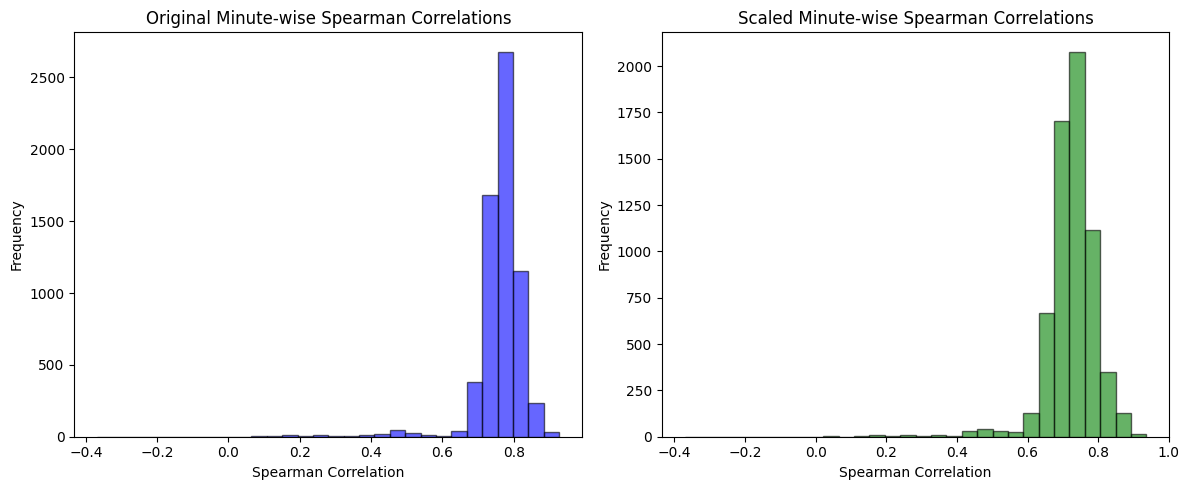

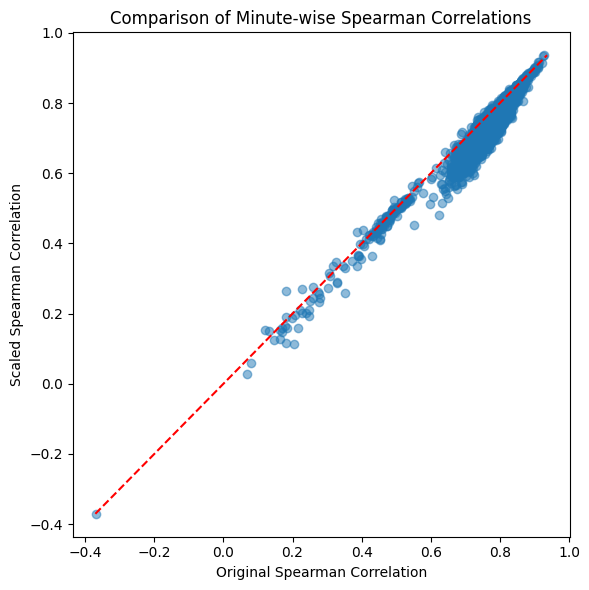

In [23]:


#--------------------------------------------------------------------------
# 1. Choose a scaling constant (epsilon) based on the distribution of vol_confidence.
#--------------------------------------------------------------------------
# Remove missing values from predicted.vol_confidence and compute the 10th percentile.
vol_conf_clean = df['predicted.vol_confidence'].dropna()
epsilon = np.percentile(vol_conf_clean, 10)
print(f"Chosen epsilon (10th percentile of predicted.vol_confidence): {epsilon:.4f}")

#--------------------------------------------------------------------------
# 2. Scale predicted volatility by dividing by (vol_confidence + epsilon)
#--------------------------------------------------------------------------
# This transformation helps moderate the left-skew: very low confidence values (which dominate)
# get an offset that prevents the scaling from being too extreme.
df['scaled_predicted_vol'] = df['predicted.volatility'] / (df['predicted.vol_confidence'] + epsilon)

#--------------------------------------------------------------------------
# 3. Define a helper function to compute Spearman correlation using ranks.
#--------------------------------------------------------------------------
def compute_spearman(group, pred_column):
    """
    Compute the Spearman correlation between a prediction column and the target
    'Y_log_vol_10min_lag_1m' within the provided group.
    """
    # Extract arrays from the group
    pred_vals = group[pred_column].values
    target_vals = group['Y_log_vol_10min_lag_1m'].values
    
    if len(pred_vals) < 2:
        return np.nan  # Not enough data to compute correlation
    
    # Compute simple ranks (using argsort twice) for both arrays.
    # (Note: This approach does not fully adjust for ties.)
    pred_ranks = pred_vals.argsort().argsort().astype(float)
    target_ranks = target_vals.argsort().argsort().astype(float)
    
    mean_pred = np.mean(pred_ranks)
    mean_target = np.mean(target_ranks)
    numerator = np.sum((pred_ranks - mean_pred) * (target_ranks - mean_target))
    denominator = np.sqrt(np.sum((pred_ranks - mean_pred)**2) * np.sum((target_ranks - mean_target)**2))
    
    return numerator / denominator if denominator != 0 else np.nan

#--------------------------------------------------------------------------
# 4. Compute minute-wise Spearman correlations for both original and scaled predictions.
#--------------------------------------------------------------------------
# Only use rows where the prediction and target are not missing.
valid_original = df.dropna(subset=['predicted.volatility', 'Y_log_vol_10min_lag_1m'])
valid_scaled   = df.dropna(subset=['scaled_predicted_vol', 'Y_log_vol_10min_lag_1m'])

# Group by date and minute.
grouped_original = valid_original.groupby(['date', 'minute'])
grouped_scaled   = valid_scaled.groupby(['date', 'minute'])

# Apply the helper function to each group.
spearman_original = grouped_original.apply(lambda g: compute_spearman(g, 'predicted.volatility'))
spearman_scaled   = grouped_scaled.apply(lambda g: compute_spearman(g, 'scaled_predicted_vol'))

# Convert the resulting Series to DataFrames for merging and comparison.
spearman_orig_df = spearman_original.reset_index(name='spearman_corr_original')
spearman_scaled_df = spearman_scaled.reset_index(name='spearman_corr_scaled')

# Merge the two results on date and minute.
spearman_comparison = pd.merge(spearman_orig_df, spearman_scaled_df, on=['date', 'minute'], how='inner')

#--------------------------------------------------------------------------
# 5. Compute summary statistics and improvement metrics.
#--------------------------------------------------------------------------
print("\nMinute-wise Spearman Correlation (Original Predicted Volatility):")
print(spearman_comparison['spearman_corr_original'].describe())

print("\nMinute-wise Spearman Correlation (Scaled Predicted Volatility):")
print(spearman_comparison['spearman_corr_scaled'].describe())

# Compute the difference (improvement) in correlations.
spearman_comparison['improvement'] = spearman_comparison['spearman_corr_scaled'] - spearman_comparison['spearman_corr_original']
print("\nImprovement (Scaled minus Original) Summary:")
print(spearman_comparison['improvement'].describe())

#--------------------------------------------------------------------------
# 6. Visualizations
#--------------------------------------------------------------------------
plt.figure(figsize=(12, 5))

# Histogram of original Spearman correlations.
plt.subplot(1, 2, 1)
plt.hist(spearman_comparison['spearman_corr_original'].dropna(), bins=30, color='blue', alpha=0.6, edgecolor='black')
plt.title("Original Minute-wise Spearman Correlations")
plt.xlabel("Spearman Correlation")
plt.ylabel("Frequency")

# Histogram of scaled Spearman correlations.
plt.subplot(1, 2, 2)
plt.hist(spearman_comparison['spearman_corr_scaled'].dropna(), bins=30, color='green', alpha=0.6, edgecolor='black')
plt.title("Scaled Minute-wise Spearman Correlations")
plt.xlabel("Spearman Correlation")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Scatter plot comparing original vs. scaled Spearman correlations.
plt.figure(figsize=(6, 6))
plt.scatter(spearman_comparison['spearman_corr_original'], spearman_comparison['spearman_corr_scaled'], alpha=0.5)
min_val = min(spearman_comparison['spearman_corr_original'].min(), spearman_comparison['spearman_corr_scaled'].min())
max_val = max(spearman_comparison['spearman_corr_original'].max(), spearman_comparison['spearman_corr_scaled'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # 45° line for reference
plt.xlabel("Original Spearman Correlation")
plt.ylabel("Scaled Spearman Correlation")
plt.title("Comparison of Minute-wise Spearman Correlations")
plt.tight_layout()
plt.show()


Chosen epsilon_vol (10th percentile of |Y_log_vol_10min_lag_1m|): 0.0002

Correlation between predicted.vol_confidence and relative_vol_error: -0.1528


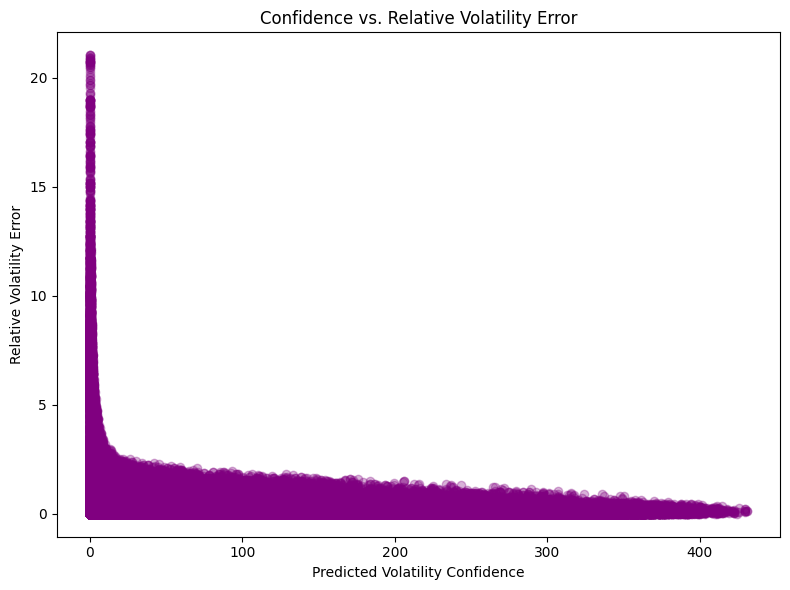

In [24]:

#############################################
# 1. Compute the Raw Error and Normalized (Relative) Error
#############################################

# Calculate the absolute error in volatility prediction.
df['vol_error'] = np.abs(df['predicted.volatility'] - df['Y_log_vol_10min_lag_1m'])

# Compute a scaling constant (epsilon_vol) for the target volatility.
# We use the 10th percentile of the absolute target values to avoid division by values that are too small.
epsilon_vol = np.percentile(np.abs(df['Y_log_vol_10min_lag_1m'].dropna()), 10)
print(f"Chosen epsilon_vol (10th percentile of |Y_log_vol_10min_lag_1m|): {epsilon_vol:.4f}")

# Compute a relative (or normalized) error that scales the error by the volatility level.
df['relative_vol_error'] = df['vol_error'] / (np.abs(df['Y_log_vol_10min_lag_1m']) + epsilon_vol)

#############################################
# 2. Compute the Correlation Between Confidence and Relative Error
#############################################

# We now want to see if the predicted volatility confidence helps us predict the (relative) error.
# In other words, we compute the Pearson correlation between 
# 'predicted.vol_confidence' and 'relative_vol_error'.

# Select only rows with valid values.
mask = (~df['predicted.vol_confidence'].isna()) & (~df['relative_vol_error'].isna())
conf_values = df.loc[mask, 'predicted.vol_confidence'].values
relative_errors = df.loc[mask, 'relative_vol_error'].values

# Compute Pearson correlation manually.
mean_conf = np.mean(conf_values)
mean_err = np.mean(relative_errors)
numerator = np.sum((conf_values - mean_conf) * (relative_errors - mean_err))
denom = np.sqrt(np.sum((conf_values - mean_conf)**2) * np.sum((relative_errors - mean_err)**2))
correlation = numerator / denom if denom != 0 else np.nan

print(f"\nCorrelation between predicted.vol_confidence and relative_vol_error: {correlation:.4f}")

#############################################
# 3. Visualization: Scatter Plot of Confidence vs. Relative Error
#############################################

plt.figure(figsize=(8, 6))
plt.scatter(conf_values, relative_errors, alpha=0.3, color='purple')
plt.xlabel("Predicted Volatility Confidence")
plt.ylabel("Relative Volatility Error")
plt.title("Confidence vs. Relative Volatility Error")
plt.tight_layout()
plt.show()



Minute-wise Spearman Correlation (excluding bottom confidence quintile):
count    6370.000000
mean        0.668490
std         0.072605
min        -0.082649
25%         0.649555
50%         0.678609
75%         0.705042
max         0.836134
Name: spearman_corr_masked, dtype: float64


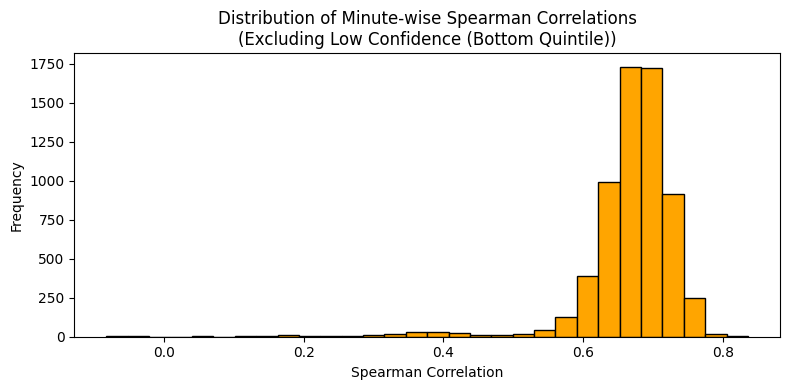

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#--------------------------------------------------------------------------
# 1. Define or reuse a helper function to compute Spearman correlation using ranks.
#--------------------------------------------------------------------------
def compute_spearman(group, pred_column):
    """
    Computes the Spearman rank correlation between the prediction column and
    the target 'Y_log_vol_10min_lag_1m' for the given DataFrame group.
    
    Parameters:
      group: DataFrame group (e.g., all rows for a specific date and minute)
      pred_column: str, name of the column containing predictions
      
    Returns:
      Spearman rank correlation value (float) or np.nan if not enough data.
    """
    # Extract predicted and target values
    pred_vals = group[pred_column].values
    target_vals = group['Y_log_vol_10min_lag_1m'].values
    
    # Need at least two points to compute a correlation
    if len(pred_vals) < 2:
        return np.nan

    # Compute ranks using a double argsort.
    pred_ranks = pred_vals.argsort().argsort().astype(float)
    target_ranks = target_vals.argsort().argsort().astype(float)
    
    # Compute means of the ranks
    mean_pred = np.mean(pred_ranks)
    mean_target = np.mean(target_ranks)
    
    # Compute covariance and standard deviations
    numerator = np.sum((pred_ranks - mean_pred) * (target_ranks - mean_target))
    denominator = np.sqrt(np.sum((pred_ranks - mean_pred)**2) * np.sum((target_ranks - mean_target)**2))
    
    return numerator / denominator if denominator != 0 else np.nan

#--------------------------------------------------------------------------
# 2. Filter the data to remove rows in the bottom confidence quintile.
#--------------------------------------------------------------------------
# Assuming your quintile column for predicted volatility confidence is named:
#    'predicted.vol_confidence_quintile'
# And that the bottom quintile is labeled 'VL'.
df_masked = df[df['predicted.vol_confidence_quintile'] != 'VL']

# Optionally, if you want to be extra sure to drop any rows missing predictions or target:
df_masked = df_masked.dropna(subset=['predicted.volatility', 'Y_log_vol_10min_lag_1m'])

#--------------------------------------------------------------------------
# 3. Group by date and minute and compute the Spearman correlation per group.
#--------------------------------------------------------------------------
grouped_masked = df_masked.groupby(['date', 'minute'])
spearman_masked = grouped_masked.apply(lambda g: compute_spearman(g, 'predicted.volatility'))

# Convert the Series to a DataFrame for easier inspection.
spearman_masked_df = spearman_masked.reset_index(name='spearman_corr_masked')

# Print summary statistics of the masked Spearman correlations.
print("\nMinute-wise Spearman Correlation (excluding bottom confidence quintile):")
print(spearman_masked_df['spearman_corr_masked'].describe())

#--------------------------------------------------------------------------
# 4. Visualization: Histogram of the Masked Spearman Correlations.
#--------------------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.hist(spearman_masked_df['spearman_corr_masked'].dropna(), bins=30, color='orange', edgecolor='black')
plt.title("Distribution of Minute-wise Spearman Correlations\n(Excluding Low Confidence (Bottom Quintile))")
plt.xlabel("Spearman Correlation")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [26]:
df.columns

Index(['minute', 'symbol', 'ts_event', 'mid', 'spread', 'imbalance',
       'Y_log_ret_10min', 'Y_log_ret_30min', 'Y_log_ret_60min',
       'Y_log_ret_10min_lag_1m', 'Y_log_ret_30min_lag_1m',
       'Y_log_ret_60min_lag_1m', 'roll_vol_10m', 'Y_log_vol_10min',
       'Y_log_vol_10min_lag_1m', 'valid_target_10m', 'valid_target_30m',
       'valid_target_60m', 'Y_log_ret_10min_partial',
       'Y_log_ret_30min_partial', 'Y_log_ret_60min_partial',
       'predicted.volatility', 'predicted.returns', 'predicted.vol_confidence',
       'predicted.ret_confidence', 'date', 'hour', 'minute_in_hour',
       'minutes_from_open', 'predicted.vol_confidence_quintile',
       'predicted.ret_confidence_quintile', 'predicted.returns_quintile',
       'predicted.volatility_quintile', 'Y_log_vol_10min_lag_1m_quintile',
       'Y_log_ret_60min_lag_1m_quintile', 'scaled_predicted_vol', 'vol_error',
       'relative_vol_error'],
      dtype='object')